# Machine Learning for Complete Intersection Calabi-Yau 3-folds

## Abstract

We consider the case of Complete Intersection Calabi-Yau manifolds of complex dimension 3 in the context of String Theory compactifications. We apply Machine Learning (ML) techniques to predict the values of the Hodge numbers $h^{1,1}$ and $h^{2,1}$ given their configuration matrix. We will however perform an extended Exploratory Data Analysis (EDA) before operating statistical inference on the data in order to get, clean and process data.

# Setup

In this section we start to load usable modules and define the operating characteristics of the machine before tackling more complex tasks.

In [1]:
# reload modules when running the notebook
%load_ext autoreload
%autoreload 2

## Specifications

The current analysis is performed on a machine with the following specifications:

In [2]:
!echo "CPU: $(head /proc/cpuinfo | awk -F': ' '/^model name/ {print $2}')"
!echo "GPU: $(lspci | awk -F': ' '/3D controller/ {print $2}')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $7}')GB available"

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev ff)
RAM: 10GB available


We then set the number of usable cores for parallel computations:

In [3]:
from os import cpu_count

# set no. of threads
THREADS = 6
MAX_THREADS = cpu_count()

# sanity check: cannot use more than available
if THREADS > MAX_THREADS:
    THREADS = MAX_THREADS

# print summary
print('Using {:d} of {:d} threads available.'.format(THREADS, MAX_THREADS))

Using 6 of 8 threads available.


We then create an operative directory structure to store, save and access files, figures and data:

In [4]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.'
IMG_DIR  = 'img'
MOD_DIR  = 'mod'
LOG_DIR  = 'log'
DAT_DIR  = 'dat'
OUT_DIR  = 'out'

# get the name of the dataset
DB_NAME = 'cicy3f'
DB_FILE = DB_NAME + '.h5'
DB_PATH = path.join(ROOT_DIR, DB_FILE)

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
print('Images: {}'.format(IMG_PATH))
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
print('Models: {}'.format(MOD_PATH))
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
print('Logs:   {}'.format(LOG_PATH))
DAT_PATH = path.join(ROOT_DIR, DAT_DIR)
print('Data:   {}'.format(DAT_PATH))
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)
print('Other:  {}'.format(OUT_PATH))

# define shortcuts for path of images, models, logs, data, etc.
imgpath = lambda s: path.join(IMG_PATH, s)
modpath = lambda s: path.join(MOD_PATH, s)
logpath = lambda s: path.join(LOG_PATH, s)
datpath = lambda s: path.join(DAT_PATH, s)
outpath = lambda s: path.join(OUT_PATH, s)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok = True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok = True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok = True)
if not path.isdir(DAT_PATH):
    makedirs(DAT_PATH, exist_ok = True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok = True)

Images: ./img
Models: ./mod
Logs:   ./log
Data:   ./dat
Other:  ./out


Important information will be saved in a log, stored in its directory:

In [5]:
import logging

from os   import path, rename
from time import strftime, gmtime

# call the log with the same name as the dataset we use
logname  = DB_NAME 
filename = path.join(LOG_PATH, DB_NAME + '.log')
ctime    = strftime('_%Y%m%d.%H%M%S', gmtime())
level    = logging.DEBUG

# rotate the log if one is already present
if path.isfile(filename):
    rename(filename, filename + ctime)

# print the log to file
log = logging.getLogger(logname + ctime)
fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s')
han = logging.FileHandler(filename = filename)
log.setLevel(level)
han.setLevel(level)
han.setFormatter(fmt)
log.addHandler(han)

# write introduction to log
log.info('\n\n'
         '----------------------------------------------\n'
         '  MACHINE LEARNING FOR CICY 3-FOLDS\n\n'
         '----------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '----------------------------------------------\n'
         '  Abstract:\n\n'
         '  In the context of String Theory\n'
         '  compactifications, we consider CICY 3-folds\n'
         '  and use machine learning to predict the\n'
         '  values of the Hodge numbers h_11 and h_21.\n\n'
        )

print('Current log: {}'.format(filename))

Current log: ./log/cicy3f.log


We finally import the modules we use in the analysis and check their versions:

In [6]:
# check Python version
import sys
assert sys.version_info.major > 2 and sys.version_info.minor > 5
print('Python version: {}.{}.{}'.format(sys.version_info.major,
                                        sys.version_info.minor,
                                        sys.version_info.micro
                                       )
     )

# import Numpy
import numpy as np
assert np.__version__ >= '1.18'
print('Numpy version:           {}'.format(np.__version__))

# import Pandas
import pandas as pd
assert pd.__version__  >= '1.0'
print('Pandas version:          {}'.format(pd.__version__))

# import Seaborn and Matplotlib
import seaborn           as sns
import matplotlib        as mpl
import matplotlib.pyplot as plt
assert mpl.__version__ >= '3.1' and sns.__version__ >= '0.10'
print('Matplotlib version:      {}'.format(mpl.__version__))
print('Seaborn version:         {}'.format(sns.__version__))
%matplotlib inline

sns.set()
subplots = lambda x, y: plt.subplots(x, y, figsize=(y*6, x*5))

# import Scikit-learn and Scikit-optimize
import sklearn
import skopt
assert sklearn.__version__ >= '0.22' and skopt.__version__ >= '0.7'
print('Scikit-learn version:    {}'.format(sklearn.__version__))
print('Scikit-optimize version: {}'.format(skopt.__version__))

# import LightGBM and check for the newest version
import lightgbm
assert lightgbm.__version__ >='2.0'
print('LightGBM version:        {}'.format(lightgbm.__version__))

# import Tensorflow (check that Keras is included: v2.0+)
import tensorflow as tf
assert tf.__version__ > '2.0'
print('Tensorflow version:      {}'.format(tf.__version__))

# check the warnings (I can't really handle UserWarnings unfortunately...)
import warnings
warnings.simplefilter('ignore', category = UserWarning)

# set the random state for reproducibility
RAND = 42
np.random.seed(RAND)
np.random.RandomState(RAND)
tf.random.set_seed(RAND)

Python version: 3.8.3
Numpy version:           1.18.5
Pandas version:          1.0.5
Matplotlib version:      3.2.2
Seaborn version:         0.10.1
Scikit-learn version:    0.22.1
Scikit-optimize version: 0.7.4
LightGBM version:        2.3.1
Tensorflow version:      2.2.0


For some computations we will be using GPU acceleration: we fix the amount of memory accessible by the GPU in order to limit its growth and to allocate only the necessary amount at runtime.

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU') # physical GPUs
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
log.debug('Set GPU memory growth.')

# Getting and Cleaning the Data

We then download the dataset and clean it to have more accessible variables during the analysis.

In [8]:
import tarfile
from urllib import request

# compose the URL
URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/'
TAR_FILE = DB_NAME + '_data.tar.gz'
TAR_PATH = path.join(ROOT_DIR, TAR_FILE)

# download the file
if not path.isfile(TAR_PATH):
    request.urlretrieve(URL_ROOT + TAR_FILE, TAR_PATH)
    
# open the tarball
if path.isfile(TAR_PATH):
    with tarfile.open(TAR_PATH, 'r') as tar:
        tar.extract(DB_FILE, ROOT_DIR)
        
if path.isfile(DB_FILE):
    log.debug('File successfully downloaded.')
else:
    log.error('Cannot download dataset!')

We can now read the database and check its composition:

In [9]:
df = pd.read_hdf(DB_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7890 entries, 1 to 7890
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   c2              7890 non-null   object 
 1   favour          7890 non-null   int64  
 2   h11             7890 non-null   int16  
 3   h21             7890 non-null   int16  
 4   isprod          7890 non-null   int64  
 5   kahlerpos       7890 non-null   int64  
 6   matrix          7890 non-null   object 
 7   size            7890 non-null   object 
 8   euler           7890 non-null   int16  
 9   num_cp          7890 non-null   int8   
 10  num_eqs         7890 non-null   int64  
 11  dim_cp          7890 non-null   object 
 12  min_dim_cp      7890 non-null   int64  
 13  max_dim_cp      7890 non-null   int64  
 14  mean_dim_cp     7890 non-null   float64
 15  median_dim_cp   7890 non-null   float64
 16  num_dim_cp      7890 non-null   object 
 17  num_cp_1        7890 non-null   i

The database contains multiple entries, some in a non numeric format (`object`, that is). It is made of:

In [10]:
print('No. of rows:    {:d}'.format(df.shape[0]))
print('No. of columns: {:d}'.format(df.shape[1]))

No. of rows:    7890
No. of columns: 31


We can take a look at a few of its entries to get an idea of its content:

In [11]:
df.head(3)

,c2,favour,h11,h21,isprod,kahlerpos,matrix,size,euler,num_cp,...,num_ex,deg_eqs,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,num_deg_eqs,rank_matrix,norm_matrix,dim_h0_amb
1,"[36, 24, 36, 24, 36, 36, 24, 36, 24, 24, 24, 2...",1,15,15,0,0,"[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[15, 18]",0,15,...,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2,2,2.0,2.0,"[0, 18, 0, 0, 0, 0, 0, 0]",14,6.0,"[6, 6, 4, 6, 6, 4, 4, 6, 6, 4, 4, 9, 6, 4, 4, ..."
2,"[24, 36, 24, 36, 36, 24, 36, 24, 24, 24, 36, 2...",1,15,15,0,0,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[15, 18]",0,15,...,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2,2,2.0,2.0,"[0, 18, 0, 0, 0, 0, 0, 0]",14,6.0,"[4, 4, 4, 4, 4, 6, 6, 4, 4, 9, 6, 9, 6, 4, 9, ..."
3,"[24, 36, 24, 36, 36, 24, 36, 36, 24, 36, 24, 2...",1,15,15,0,0,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[15, 18]",0,15,...,0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",2,2,2.0,2.0,"[0, 18, 0, 0, 0, 0, 0, 0]",14,6.0,"[4, 4, 6, 4, 4, 6, 6, 4, 4, 6, 6, 4, 6, 6, 6, ..."


As we can see the database need to be tidied since there are columns holding multiple observations. We will try to expand over columns the vector quantities to be more accessible. However we will also save the shape of each of the original columns to have use later.

First of all, however, we need to extract vector and matrices from their sparse format into a dense format:

In [12]:
def extract_series(series: pd.Series) -> pd.Series:
    '''
    Extract a Pandas series into its dense format.
    
    Required arguments:
        series: the pandas series.
        
    Returns:
        the pandas series in dense format.
    '''
    # avoid direct overwriting
    series = series.copy()
    
    # cget the maximum size of each axis
    max_shape = series.apply(np.shape).max()
    
    # return the transformed series
    if np.prod(max_shape) > 1:
        # compute the necessary shift and apply it
        offset = lambda s: [(0, max_shape[i] - np.shape(s)[i])
                            for i in range(len(max_shape))
                           ]
        return series.apply(lambda s: np.pad(s, offset(s), mode='constant'))
    else:
        return series
    
# applyit to all variables of the dataset 
df = df.apply(extract_series)

We then save the shape of each variable to be accessible later:

In [13]:
shape_dict = df.applymap(np.shape).\
                apply(np.unique).\
                to_dict(orient='records')[0]

We now flatten each vector and expand it over the rows to have only one observation for each variable. We also take this change to reorder the dataframe to have the prediction labels to the left and be able to join the variables to the right:

In [14]:
def explode_variables(series: pd.Series) -> pd.DataFrame:
    '''
    Take one variable and explode its components in a new column.
    
    Required arguments:
        series: the variable to explode.
        
    Returns:
        a dataframe containing one observable for each column.
    '''
    # avoid direct overwriting
    series = series.copy()
    
    if series.apply(lambda x: np.prod(np.shape(x))).max() == 1:
        return series
    else:
        # flatten the array
        series = series.apply(lambda x: np.reshape(x, (-1,)))

        # explode over columns
        series = series.apply(pd.Series).\
                        rename(columns=lambda x: \
                                       series.name + '_{}'.format(x+1))

        return series
    
# decide the new order of the columns
column_list = ['h11', 'h21', 'euler',
               'c2', 'kahlerpos', 'size', 'isprod', 'favour',
               'num_cp', 'num_eqs',
               'dim_h0_amb',
               'dim_cp', 'num_dim_cp',
               'min_dim_cp', 'max_dim_cp', 'mean_dim_cp', 'median_dim_cp',
               'num_cp_1', 'num_cp_2', 'num_cp_neq1',
               'num_over', 'num_ex',
               'deg_eqs', 'num_deg_eqs',
               'min_deg_eqs', 'max_deg_eqs', 'mean_deg_eqs', 'median_deg_eqs',
               'rank_matrix', 'norm_matrix',
               'matrix' 
              ]

# create a new data frame and "left join" each exploded variable
df_new = pd.DataFrame(index=df.index)
for f in column_list:
    df_new = df_new.join(explode_variables(df[f]))
    
# overwrite old file
df = df_new.copy()
del df_new

We then check if there are any duplicated rows in the dataset (i.e. columns which have identical values all over):

In [15]:
df.duplicated().rename('duplicates').agg({'sum', 'mean'})

sum     0.0
mean    0.0
Name: duplicates, dtype: float64

Since there are none, we do not need to delete any. We finally save the resulting dataset to file.

In [16]:
df.to_csv(datpath(DB_NAME + '_tidy.csv'), index=False)
log.debug('Tidy database has been saved to file.')

# Exploratory Data Analysis

In this section we present the EDA on the tidy dataset. We intend to study and present properties and visualisation of the data we are going to study.

We start from studying the distribution of the prediction labels:

In [17]:
labels_full = df[['h11', 'h21']]
labels_full.describe()

,h11,h21
count,7890.000000,7890.000000
mean,7.419772,28.744740
std,2.250891,8.577282
min,0.000000,0.000000
25%,6.000000,23.000000
50%,7.000000,27.000000
75%,9.000000,33.000000
max,19.000000,101.000000


In particular we see that they involve two different scales of values ($h^{1,1}$ is order $10$ while $h^{2,1}$ is order $100$). We plot the histogram of their distribution:

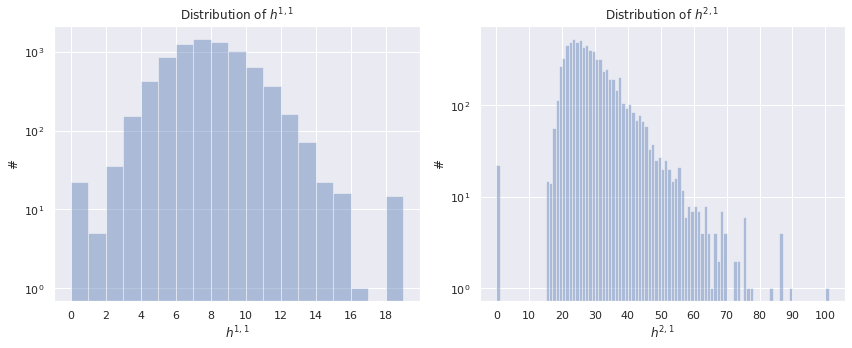

In [18]:
fig, ax = subplots(1,2)

sns.distplot(labels_full['h11'],
             bins=np.arange(min(labels_full['h11']),
                            max(labels_full['h11'])+1
                           ),
             kde=False,
             ax=ax[0]
            )
ax[0].set(title='Distribution of $h^{1,1}$',
          xlabel='$h^{1,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_full['h11']),
                           max(labels_full['h11']),
                           2
                          )
         )

sns.distplot(labels_full['h21'],
             bins=np.arange(min(labels_full['h21']),
                            max(labels_full['h21'])+1
                           ),
             kde=False,
             ax=ax[1]
            )
ax[1].set(title='Distribution of $h^{2,1}$',
          xlabel='$h^{2,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_full['h21']),
                           max(labels_full['h21']),
                           10
                          )
         )

plt.tight_layout()
plt.savefig(imgpath('label-distribution_fav.pdf'), dpi=150, format='pdf')

In this analysis we will however be interested in a particular subset of the distributions: we consider only matrices which are not products of other subspaces (i.e. we choose to keep `isprod` $= 0$) and remove large outliers of the distribution.

In [19]:
# remove product spaces and large outliers
df_clean = df.loc[(df['isprod'] == 0) &
                  ((df['h11'] >= 1) & (df['h11'] <= 16)) &
                  ((df['h21'] >= 1) & (df['h21'] <= 86))
                 ].reset_index(drop=True)
labels_clean = df_clean[['h11', 'h21']]

The new distribution of $h^{1,1}$ and $h^{2,1}$ can then be compared with what we had before:

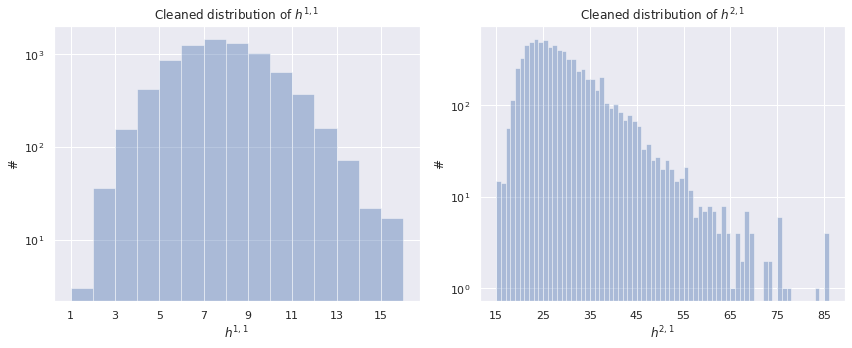

In [20]:
fig, ax = subplots(1,2)

sns.distplot(labels_clean['h11'],
             bins=np.arange(min(labels_clean['h11']),
                            max(labels_clean['h11']) + 1
                           ),
             kde=False,
             ax=ax[0]
            )
ax[0].set(title='Cleaned distribution of $h^{1,1}$',
          xlabel='$h^{1,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_clean['h11']),
                           max(labels_clean['h11']),
                           2
                          )
         )

sns.distplot(labels_clean['h21'],
             bins=np.arange(min(labels_clean['h21']),
                            max(labels_clean['h21']) + 1
                           ),
             kde=False,
             ax=ax[1]
            )
ax[1].set(title='Cleaned distribution of $h^{2,1}$',
          xlabel='$h^{2,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_clean['h21']),
                           max(labels_clean['h21']),
                           10
                          )
         )

plt.tight_layout()
plt.savefig(imgpath('label-distribution-clean_fav.pdf'), dpi=150, format='pdf')

As we can see the distribution is much cleaner in this case and can be used for training. We finally use a boxplot to better visualise the differences in the plots:

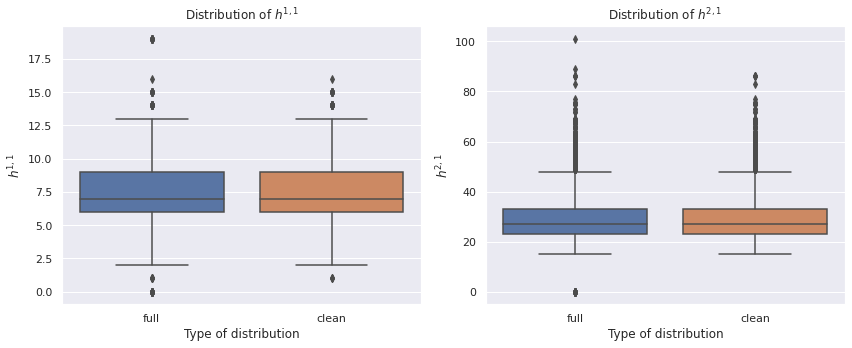

In [21]:
box_data = {'type':       ['full'] * labels_full.shape[0] +
                          ['clean'] * labels_clean.shape[0],
            'h11_values': np.hstack((labels_full['h11'].values,
                                     labels_clean['h11'].values
                                    )
                                   ),
            'h21_values': np.hstack((labels_full['h21'].values,
                                     labels_clean['h21'].values
                                    )
                                   )
           }

fig, ax = subplots(1,2)

sns.boxplot(data=pd.DataFrame(box_data),
            x='type',
            y='h11_values',
            ax=ax[0]
           )
ax[0].set(title='Distribution of $h^{1,1}$',
          xlabel='Type of distribution',
          ylabel='$h^{1,1}$'
         )

sns.boxplot(data=pd.DataFrame(box_data),
            x='type',
            y='h21_values',
            ax=ax[1]
           )
ax[1].set(title='Distribution of $h^{2,1}$',
          xlabel='Type of distribution',
          ylabel='$h^{2,1}$'
         )

plt.tight_layout()
plt.savefig(imgpath('label-distribution-compare_fav.pdf'),
            dpi=150,
            format='pdf'
           )

We then present the correlation matrix of the scalar values in the dataset. First we select the values necessary for the computation:

In [22]:
scalar_columns = [col for col in column_list if np.prod(shape_dict[col]) == 1
                                             and col != 'isprod'
                                             and col != 'favour'
                 ]

We then plot the values in a heatmap.

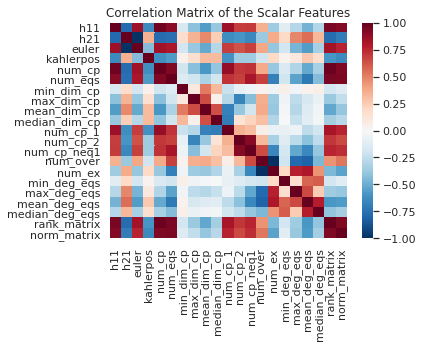

In [23]:
fig, ax = subplots(1,1)

sns.heatmap(df_clean[scalar_columns].corr(),
            vmin=-1.0,
            vmax=1.0,
            norm=mpl.colors.DivergingNorm(0.0),
            cmap='RdBu_r',
            ax=ax
           )
ax.set_title('Correlation Matrix of the Scalar Features')

plt.tight_layout()
plt.savefig(imgpath('corr-matrix_fav.pdf'), dpi=150, format='pdf')

As we can see the most engineered features are quickly highly correlated and may help in statistical inference of the labels.

We then show the distribution of the labels as a function of several scalar values: we choose the engineered features which show the highest correlation with the labels:

In [24]:
# define a function to extract the information
def get_unique(df: pd.DataFrame, feature: str, label: str) -> pd.DataFrame:
    '''
    Get the unique values and the no. of occurrencies.
    
    Required arguments:
        feature: the name of the feature,
        label:   the name of the label.
        
    Returns:
        a dataframe with the information.
    '''
    counts = df.groupby(feature)[label].value_counts()
    
    # store data in a dataframe
    data = {feature:      [c[0] for c in counts.index],
            label:        [c[1] for c in counts.index],
            'frequency':  counts.values
           }
    return pd.DataFrame(data)

We then plot the distributions of the labels with respect to correlated data:

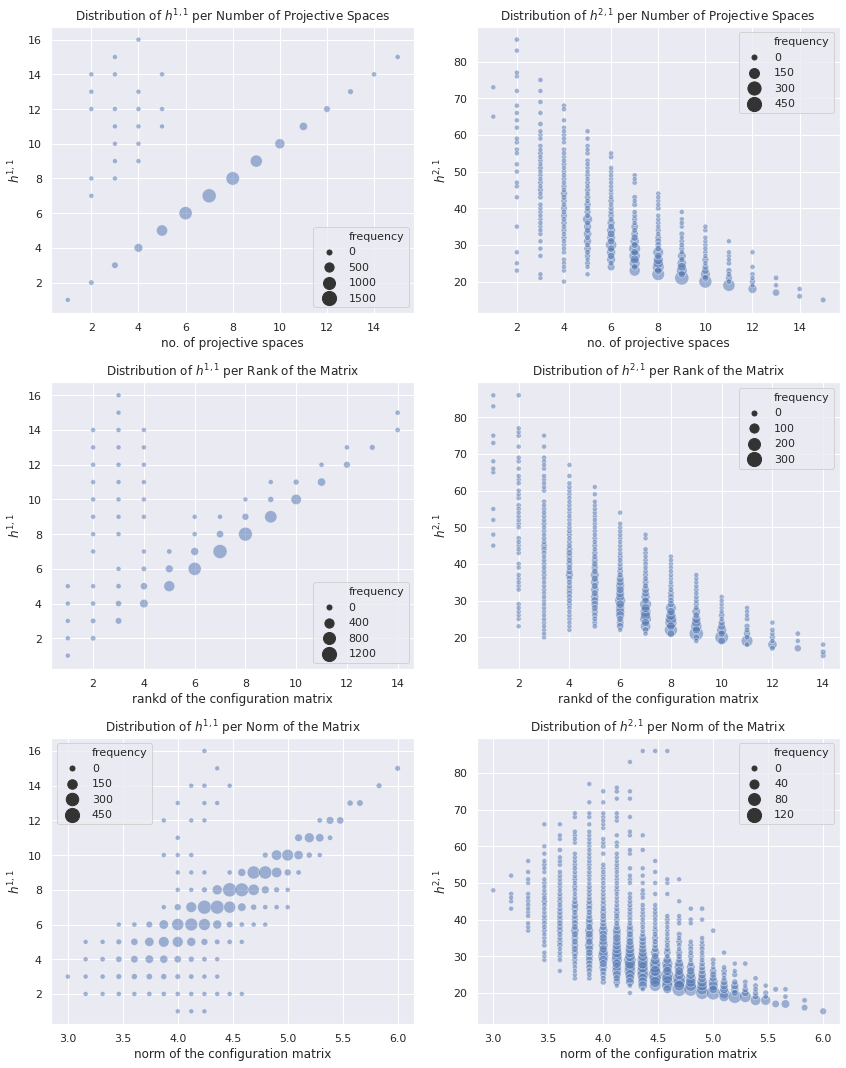

In [25]:
fig, ax = subplots(3,2)

sns.scatterplot(data=get_unique(df_clean, 'num_cp', 'h11'),
                x='num_cp',
                y='h11',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[0,0]
               )
ax[0,0].set(title='Distribution of $h^{1,1}$ per Number of Projective Spaces',
            xlabel='no. of projective spaces',
            ylabel='$h^{1,1}$'
           )
sns.scatterplot(data=get_unique(df_clean, 'num_cp', 'h21'),
                x='num_cp',
                y='h21',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[0,1]
               )
ax[0,1].set(title='Distribution of $h^{2,1}$ per Number of Projective Spaces',
            xlabel='no. of projective spaces',
            ylabel='$h^{2,1}$'
           )

sns.scatterplot(data=get_unique(df_clean, 'rank_matrix', 'h11'),
                x='rank_matrix',
                y='h11',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[1,0]
               )
ax[1,0].set(title='Distribution of $h^{1,1}$ per Rank of the Matrix',
            xlabel='rankd of the configuration matrix',
            ylabel='$h^{1,1}$'
           )
sns.scatterplot(data=get_unique(df_clean, 'rank_matrix', 'h21'),
                x='rank_matrix',
                y='h21',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[1,1]
               )
ax[1,1].set(title='Distribution of $h^{2,1}$ per Rank of the Matrix',
            xlabel='rankd of the configuration matrix',
            ylabel='$h^{2,1}$'
           )

sns.scatterplot(data=get_unique(df_clean, 'norm_matrix', 'h11'),
                x='norm_matrix',
                y='h11',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[2,0]
               )
ax[2,0].set(title='Distribution of $h^{1,1}$ per Norm of the Matrix',
            xlabel='norm of the configuration matrix',
            ylabel='$h^{1,1}$'
           )
sns.scatterplot(data=get_unique(df_clean, 'norm_matrix', 'h21'),
                x='norm_matrix',
                y='h21',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[2,1]
               )
ax[2,1].set(title='Distribution of $h^{2,1}$ per Norm of the Matrix',
            xlabel='norm of the configuration matrix',
            ylabel='$h^{2,1}$'
           )

plt.tight_layout()
plt.savefig(imgpath('distr-labels-corr-feat_fav.pdf'), dpi=150, format='pdf')

## PCA and K-Means Clustering

We then consider two more different approached to the dataset. Namely we study the Principal Components Analysis (PCA) and the clustering (using **K-means**) of the components of the matrix.

In [26]:
matrix_comp = df_clean.filter(regex='matrix_.*')

We start from the PCA of the matrix by first studying its Singular Value Decomposition (SVD), thus showing the amount of variance retained by each principal component. We first shift the matrix components to have a central distribution with 0 mean:

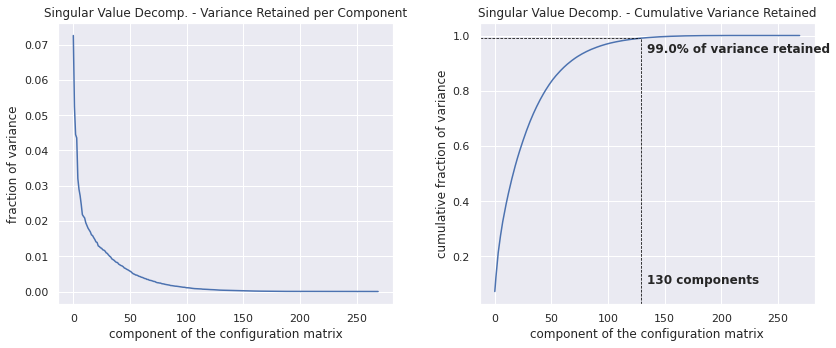

In [27]:
# center the distribution before proceeding
matrix_ctr = matrix_comp - matrix_comp.apply('mean')

# compute the SVD
log.info('Computing SVD.')
_, S, _ = np.linalg.svd(matrix_ctr)

# compute the variance (and its cumulative sum)
S2    = S ** 2 / np.sum(S ** 2)
S2cum = np.cumsum(S2)

# plot the retained variance by component
fig, ax = subplots(1,2)

sns.lineplot(x=np.arange(len(S2)),
             y=S2,
             ax=ax[0]
            )
ax[0].set(title='Singular Value Decomp. - Variance Retained per Component',
          xlabel='component of the configuration matrix',
          ylabel='fraction of variance'
         )

sns.lineplot(x=np.arange(len(S2cum)),
             y=S2cum,
             ax=ax[1]
            )
ax[1].set(title='Singular Value Decomp. - Cumulative Variance Retained',
          xlabel='component of the configuration matrix',
          ylabel='cumulative fraction of variance'
         )

# add lines where part of the total variance is retained
var_ret = 0.99
ax[1].axhline(var_ret,
              xmin=0,
              xmax=np.argmax(S2cum >= var_ret) / len(S2cum),
              linestyle='--',
              linewidth=0.75,
              c='black'
             )
ax[1].axvline(np.argmax(S2cum >= var_ret),
              ymin=0,
              ymax=var_ret / ax[1].get_ylim()[1],
              linestyle='--',
              linewidth=0.75, c='black'
             )
ax[1].text(np.argmax(S2cum >= var_ret) + 5, var_ret - 0.05,
           '{}% of variance retained'.format(var_ret * 100),
           fontweight='bold'
          )
ax[1].text(np.argmax(S2cum >= var_ret) + 5, 0.1,
           '{:d} components'.format(np.argmax(S2cum >= var_ret) + 1),
           fontweight='bold'
          )

plt.tight_layout()
plt.savefig(imgpath('svd_fav.pdf'), dpi=150, format='pdf')

We can then directly compute the projection on the principal components retaining 99% of the variance inside the data (we will also compute the same object with up to 3 components for visualisation purposes):

In [28]:
from sklearn.decomposition import PCA

# compute the "good" PCA
log.info('Computing PCA.')
matrix_comp_pca = PCA(n_components=0.99).fit_transform(matrix_comp)
matrix_comp_pca = pd.DataFrame(matrix_comp_pca).\
                     rename(columns=lambda x: 'pca_' + str(x+1))

# add the PCA to the dataset
df = df_clean.join(matrix_comp_pca)

# compute the "simple" PCA
matrix_comp_vis2 = PCA(n_components=2).fit_transform(matrix_comp)
matrix_comp_vis2 = pd.DataFrame(matrix_comp_vis2).\
                      rename(columns=lambda x: 'pca_' + str(x+1))
matrix_comp_vis3 = PCA(n_components=3).fit_transform(matrix_comp)
matrix_comp_vis3 = pd.DataFrame(matrix_comp_vis3).\
                      rename(columns=lambda x: 'pca_' + str(x+1))

The visualisation can be performed by plotting the values of the PCA on a scatter plot:

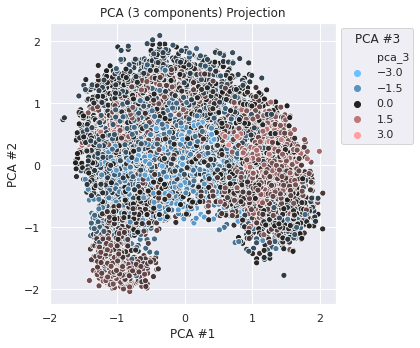

In [29]:
fig, ax = subplots(1,1)

sns.scatterplot(data=matrix_comp_vis3,
                x='pca_1',
                y='pca_2',
                hue='pca_3',
                palette=sns.diverging_palette(240, 10,
                                              s=100,
                                              l=75,
                                              center='dark',
                                              as_cmap=True
                                             ),
                ax=ax
               )
ax.set(title='PCA (3 components) Projection',
       xlabel='PCA #1',
       ylabel='PCA #2'
      )
ax.legend(title='PCA #3',
          loc='upper left',
          bbox_to_anchor=(1.0, 1.0)
         )

plt.tight_layout()
plt.savefig(imgpath('pca-3_fav.pdf'), dpi=150, format='pdf')

We then consider the clustering algorithm:

In [30]:
from sklearn.cluster import KMeans

# compute the labels of the clusters
kmeans = lambda n: KMeans(n_clusters=n,
                          random_state=RAND).fit_predict(matrix_comp)

# add labels to the dataset
cluster_range = range(2,16)
for n in cluster_range:
    log.info('Computing KMeans with {:d} clusters'.format(n))
    df['kmeans_' + str(n)] = kmeans(n)

We can visualise the clusterisation of the matrix by plotting the labels we predict using the clusters as colour map (we chose to plot for instance the case of 2 and 15 clusters):

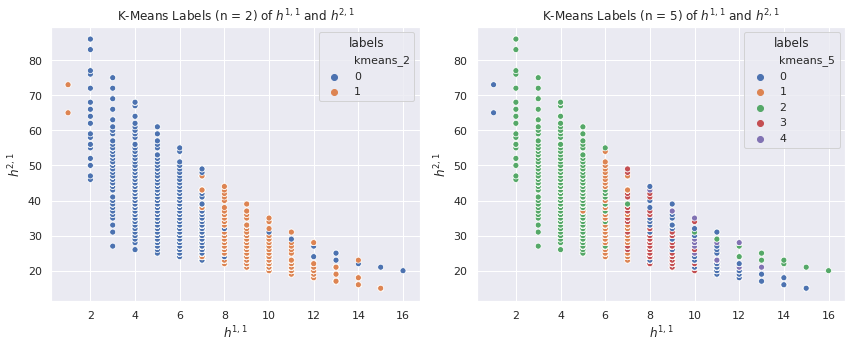

In [31]:
fig, ax = subplots(1,2)

sns.scatterplot(data=df,
                x='h11',
                y='h21',
                hue='kmeans_2',
                ax=ax[0]
               )
ax[0].set(title='K-Means Labels (n = 2) of $h^{1,1}$ and $h^{2,1}$',
          xlabel='$h^{1,1}$',
          ylabel='$h^{2,1}$'
         )
            
ax[0].legend(title='labels')

sns.scatterplot(data=df,
                x='h11',
                y='h21',
                hue='kmeans_5',
                palette=sns.color_palette(n_colors=5),
                ax=ax[1]
               )
ax[1].set(title='K-Means Labels (n = 5) of $h^{1,1}$ and $h^{2,1}$',
          xlabel='$h^{1,1}$',
          ylabel='$h^{2,1}$'
         )
ax[1].legend(title='labels')

plt.tight_layout()
plt.savefig(imgpath('clusters_fav.pdf'), dpi=150, format='pdf')

Ultimately we save the dataset to file for further use:

In [32]:
df.to_csv(datpath(DB_NAME + '_full.csv'), index=False)
log.info('Full database has been saved to file.')

# Feature Importance and Selection

We then consider the variable ranking obtained by fitting a random forest algorithm to the data we find. We will be interested in keeping only the most important features.

For this part of the analysis, we drop the labels from the dataset and we divide it into two separate dataframes, one containing engineered features and the matrix, and the other containing the PCA instead of the matrix to avoid duplication:

In [33]:
# drop labels and non topological features
drop_columns = list(\
    df.filter(regex='euler|^c2.*|^is.*|^fav.*|^size.*|^kahl.*'))

# separate pca and matrix columns
pca_columns  = list(df.filter(regex='^pca.*'))
mat_columns  = list(df.filter(regex='^matr.*'))

# drop columns and shuffle the dataframe
pca_feat = df.drop(columns=drop_columns).drop(columns=mat_columns).\
                                        sample(frac=1, random_state=RAND)
mat_feat = df.drop(columns=drop_columns).drop(columns=pca_columns).\
                                        sample(frac=1, random_state=RAND)

# take the labels (either mat_feat or pca_feat are equally ok)
h11 = mat_feat['h11'].values.reshape(-1,)
h21 = mat_feat['h21'].values.reshape(-1,)

pca_feat = pca_feat.drop(columns=['h11', 'h21'])
mat_feat = mat_feat.drop(columns=['h11', 'h21'])

Variable ranking is achieved by training a decision tree on the data. We use a random forest as an ensemble technique for using decision trees and bootstrap after standardisation of the samples:

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble      import RandomForestRegressor
from sklearn.pipeline      import Pipeline

# define the pipeline
pip_list = [('standardisation', StandardScaler()),
            ('variableranking', RandomForestRegressor(n_estimators=100,
                                                      n_jobs=THREADS,
                                                      random_state=RAND
                                                     )
            )
           ]

# fit the training data and recover the importance of the features
log.info('Fitting random forest for variable ranking.')
rf_mat_h11 = Pipeline(pip_list, verbose=True).fit(mat_feat, h11).\
             named_steps['variableranking'].feature_importances_
rf_pca_h11 = Pipeline(pip_list, verbose=True).fit(pca_feat, h11).\
             named_steps['variableranking'].feature_importances_
rf_mat_h21 = Pipeline(pip_list, verbose=True).fit(mat_feat, h21).\
             named_steps['variableranking'].feature_importances_
rf_pca_h21 = Pipeline(pip_list, verbose=True).fit(pca_feat, h21).\
             named_steps['variableranking'].feature_importances_

[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.1s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=   0.9s
[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=   5.9s
[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=   3.3s
[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=  18.1s


We can then collect the variable importances from the previous pipelines:

In [35]:
import re

# get the labels
mat_labels = list(mat_feat.columns)
pca_labels = list(pca_feat.columns)

# stem each label in the list:
mat_labels_stem = [re.sub('^matrix_.*', 'matrix', s)
                   for s in mat_labels]
mat_labels_stem = [re.sub('^dim_h0_amb_.*', 'dim_h0_amb', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^dim_cp_.*', 'dim_cp', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^num_dim_cp_.*', 'num_dim_cp', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^deg_eqs_.*', 'deg_eqs', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^num_deg_eqs_.*', 'num_deg_eqs', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^kmeans_.*', 'kmeans', s)
                   for s in mat_labels_stem]

pca_labels_stem = [re.sub('^pca_.*', 'pca', s)
                   for s in pca_labels]
pca_labels_stem = [re.sub('^dim_h0_amb_.*', 'dim_h0_amb', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^dim_cp_.*', 'dim_cp', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^num_dim_cp_.*', 'num_dim_cp', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^deg_eqs_.*', 'deg_eqs', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^num_deg_eqs_.*', 'num_deg_eqs', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^kmeans_.*', 'kmeans', s)
                   for s in pca_labels_stem]

# create the database
mat_imp = pd.DataFrame({'group': mat_labels_stem,
                        'h11':   rf_mat_h11,
                        'h21':   rf_mat_h21
                       },
                       index=mat_labels
                      )
pca_imp = pd.DataFrame({'group': pca_labels_stem,
                        'h11':   rf_pca_h11,
                        'h21':   rf_pca_h21
                       },
                       index=pca_labels
                      )

Finally we can plot the various labels. We start from the scalar variables:

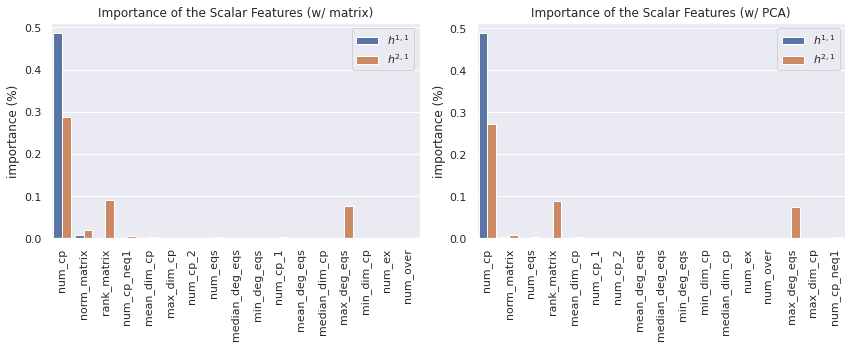

In [36]:
scalar_variables = ['num_cp', 'num_eqs',
                    'min_dim_cp', 'max_dim_cp',
                    'mean_dim_cp', 'median_dim_cp',
                    'num_cp_1', 'num_cp_2', 'num_cp_neq1',
                    'num_over', 'num_ex',
                    'min_deg_eqs', 'max_deg_eqs',
                    'mean_deg_eqs', 'median_deg_eqs',
                    'rank_matrix', 'norm_matrix'
                   ]

# save scalar importances
mat_scal_val = mat_imp.loc[scalar_variables]
mat_scal_val = mat_scal_val.sort_values(by='h11', ascending=False)
pca_scal_val = pca_imp.loc[scalar_variables]
pca_scal_val = pca_scal_val.sort_values(by='h11', ascending=False)

# plot the scalar features
fig, ax = subplots(1,2)

sns.barplot(data=pd.melt(mat_scal_val, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[0]
           )
ax[0].set(title='Importance of the Scalar Features (w/ matrix)',
          xlabel='',
          ylabel='importance (%)'
         )
ax[0].set_xticklabels(mat_scal_val['group'], rotation=90, ha='center')
leg = ax[0].legend(title='')
leg.get_texts()[0].set_text('$h^{1,1}$')
leg.get_texts()[1].set_text('$h^{2,1}$')

sns.barplot(data=pd.melt(pca_scal_val, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[1]
           )
ax[1].set(title='Importance of the Scalar Features (w/ PCA)',
          xlabel='',
          ylabel='importance (%)'
         )
ax[1].set_xticklabels(pca_scal_val['group'], rotation=90, ha='center')
leg = ax[1].legend(title='')
leg.get_texts()[0].set_text('$h^{1,1}$')
leg.get_texts()[1].set_text('$h^{2,1}$')

plt.tight_layout()
plt.savefig(imgpath('scalar-features_fav.pdf'), dpi=150, format='pdf')

We can proceed with the same plots for the vector features:

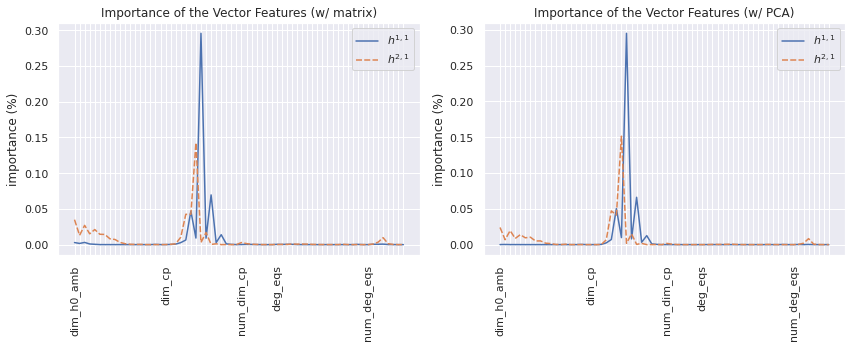

In [37]:
vector_features = ['dim_h0_amb',
                   'dim_cp', 'num_dim_cp',
                   'deg_eqs', 'num_deg_eqs'
                  ]

# save vector importances
mat_vec_val = mat_imp.loc[mat_imp['group'].isin(vector_features)].\
                      reset_index(drop=False)
pca_vec_val = pca_imp.loc[pca_imp['group'].isin(vector_features)].\
                      reset_index(drop=False)

# plot the vector features
fig, ax = subplots(1,2)

xticklabels = []
for f in vector_features:
    xticklabels.append(f)
    for n in range(np.prod(shape_dict[f]) - 1):
        xticklabels.append('')

sns.lineplot(data=mat_vec_val[['h11', 'h21']],
             ax=ax[0]
            )
ax[0].set(title='Importance of the Vector Features (w/ matrix)',
          xlabel='',
          ylabel='importance (%)',
          xticks=np.arange(mat_vec_val.shape[0])
         )
ax[0].set_xticklabels(xticklabels, rotation=90, ha='center')
ax[0].legend(['$h^{1,1}$', '$h^{2,1}$'])

sns.lineplot(data=pca_vec_val[['h11', 'h21']],
             ax=ax[1]
            )
ax[1].set(title='Importance of the Vector Features (w/ PCA)',
          xlabel='',
          ylabel='importance (%)',
          xticks=np.arange(pca_vec_val.shape[0])
         )
ax[1].set_xticklabels(xticklabels, rotation=90, ha='center')
ax[1].legend(['$h^{1,1}$', '$h^{2,1}$'])

plt.tight_layout()
plt.savefig(imgpath('vector-features_fav.pdf'), dpi=150, format='pdf')

We then proceed with the matrix and PCA themselves:

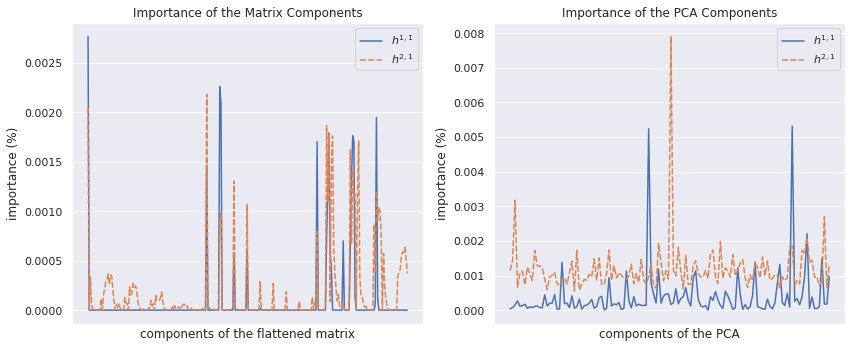

In [38]:
fig, ax = subplots(1,2)

sns.lineplot(data=mat_imp[mat_imp['group'] == 'matrix'][['h11', 'h21']],
             ax=ax[0]
            )
ax[0].set(title='Importance of the Matrix Components',
          xlabel='components of the flattened matrix',
          ylabel='importance (%)',
          xticks=np.arange(matrix_comp.shape[1], 10)
         )
ax[0].legend(['$h^{1,1}$', '$h^{2,1}$'])

sns.lineplot(data=pca_imp[pca_imp['group'] == 'pca'][['h11', 'h21']],
             ax=ax[1]
            )
ax[1].set(title='Importance of the PCA Components',
          xlabel='components of the PCA',
          ylabel='importance (%)',
          xticks=np.arange(matrix_comp_pca.shape[1], 10)
         )
ax[1].legend(['$h^{1,1}$', '$h^{2,1}$'])

plt.tight_layout()
plt.savefig(imgpath('tensor-features_fav.pdf'), dpi=150, format='pdf')

We then show the clustering importance for each cluster:

In [39]:
# define the tick labels
xticklabels = [str(n) + ' clusters' for n in cluster_range]

And plot the data:

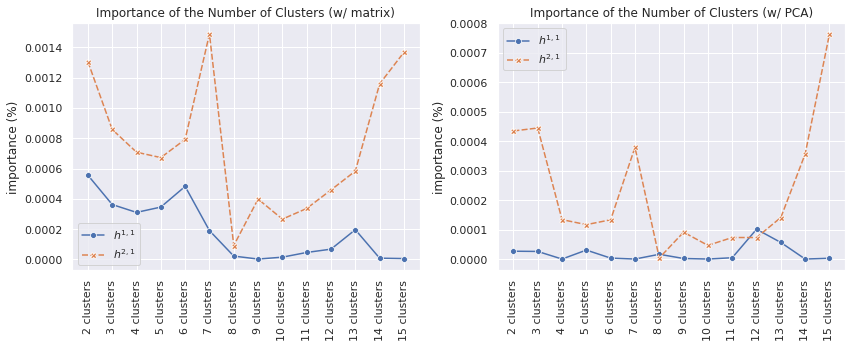

In [40]:
# plot the cluster features
fig, ax = subplots(1,2)

sns.lineplot(data=mat_imp[mat_imp['group'] == 'kmeans'][['h11', 'h21']],
             markers=True,
             ax=ax[0]
            )
ax[0].set(title='Importance of the Number of Clusters (w/ matrix)',
          xlabel='',
          ylabel='importance (%)'
         )
ax[0].set_xticklabels(xticklabels, rotation=90, ha='center')
ax[0].legend(['$h^{1,1}$', '$h^{2,1}$'])

sns.lineplot(data=pca_imp[pca_imp['group'] == 'kmeans'][['h11', 'h21']],
             markers=True,
             ax=ax[1]
            )
ax[1].set(title='Importance of the Number of Clusters (w/ PCA)',
          xlabel='',
          ylabel='importance (%)'
         )
ax[1].set_xticklabels(xticklabels, rotation=90, ha='center')
ax[1].legend(['$h^{1,1}$', '$h^{2,1}$'])

plt.tight_layout()
plt.savefig(imgpath('cluster-features_fav.pdf'), dpi=150, format='pdf')

Finally we show the sum vector and tensor features:

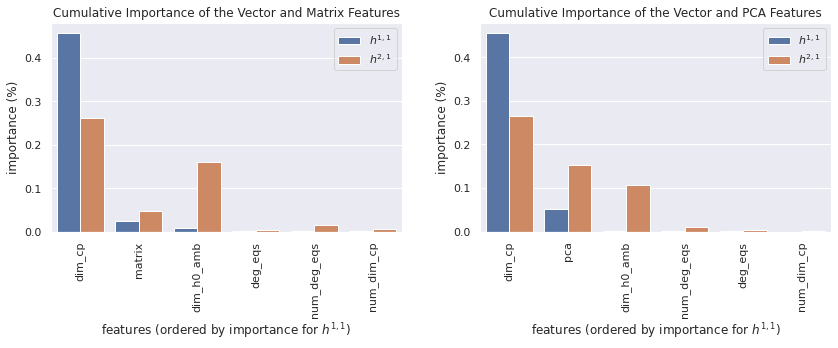

In [41]:
sum_mat_imp = mat_imp[(mat_imp['group'].isin(vector_features)) |
                      (mat_imp['group'] == 'matrix')
                     ].groupby('group').sum().sort_values(by='h11',
                                                          ascending=False
                                                         ).reset_index()
sum_pca_imp = pca_imp[(pca_imp['group'].isin(vector_features)) |
                      (pca_imp['group'] == 'pca')
                     ].groupby('group').sum().sort_values(by='h11',
                                                          ascending=False
                                                         ).reset_index()

fig, ax = subplots(1,2)

sns.barplot(data=pd.melt(sum_mat_imp, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[0]
           )
ax[0].set(title='Cumulative Importance of the Vector and Matrix Features',
          xlabel='features (ordered by importance for $h^{1,1}$)',
          ylabel='importance (%)'
         )
ax[0].set_xticklabels(sum_mat_imp['group'], rotation=90, ha='center')
leg = ax[0].legend(title='')
leg.get_texts()[0].set_text('$h^{1,1}$')
leg.get_texts()[1].set_text('$h^{2,1}$')

sns.barplot(data=pd.melt(sum_pca_imp, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[1]
           )
ax[1].set(title='Cumulative Importance of the Vector and PCA Features',
          xlabel='features (ordered by importance for $h^{1,1}$)',
          ylabel='importance (%)'
         )
ax[1].set_xticklabels(sum_pca_imp['group'], rotation=90, ha='center')
leg = ax[1].legend(title='')
leg.get_texts()[0].set_text('$h^{1,1}$')
leg.get_texts()[1].set_text('$h^{2,1}$')

plt.tight_layout()
plt.savefig(imgpath('vector-tensor-features_fav.pdf'), dpi=150, format='pdf')

As last step we show the cumulative importance of scalar, vector, cluster and tensor features:

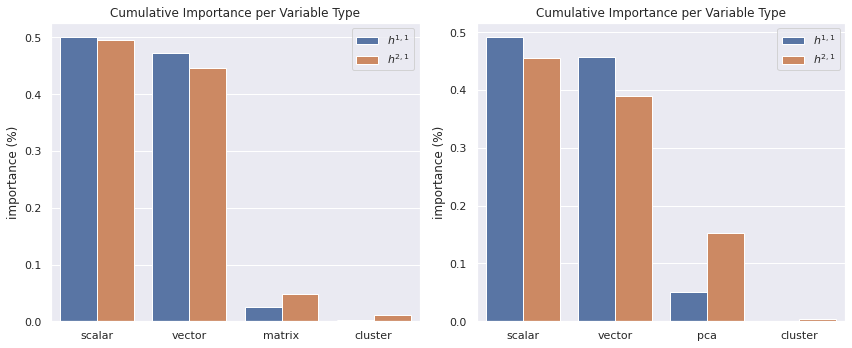

In [42]:
# add type label to be able to group the results
mat_imp.loc[mat_imp['group'].isin(scalar_variables), 'type'] = 'scalar'
mat_imp.loc[mat_imp['group'].isin(vector_features), 'type']  = 'vector'
mat_imp.loc[mat_imp['group'] == 'kmeans', 'type']            = 'cluster'
mat_imp.loc[mat_imp['group'] == 'matrix', 'type']            = 'matrix'

pca_imp.loc[pca_imp['group'].isin(scalar_variables), 'type'] = 'scalar'
pca_imp.loc[pca_imp['group'].isin(vector_features), 'type']  = 'vector'
pca_imp.loc[pca_imp['group'] == 'kmeans', 'type']            = 'cluster'
pca_imp.loc[pca_imp['group'] == 'pca', 'type']               = 'pca'

# compute the sum of the importance for each type
mat_full_imp = mat_imp.groupby('type').sum().sort_values('h11',
                                                         ascending=False).\
                                             reset_index()
pca_full_imp = pca_imp.groupby('type').sum().sort_values('h11',
                                                         ascending=False).\
                                             reset_index()

# plot the results
fig, ax = subplots(1,2)

sns.barplot(data=pd.melt(mat_full_imp, id_vars='type'),
            x='type',
            y='value',
            hue='variable',
            ax=ax[0]
           )
ax[0].set(title='Cumulative Importance per Variable Type',
          xlabel='',
          ylabel='importance (%)'
         )
leg = ax[0].legend(title='')
leg.get_texts()[0].set_text('$h^{1,1}$')
leg.get_texts()[1].set_text('$h^{2,1}$')

sns.barplot(data=pd.melt(pca_full_imp, id_vars='type'),
            x='type',
            y='value',
            hue='variable',
            ax=ax[1]
           )
ax[1].set(title='Cumulative Importance per Variable Type',
          xlabel='',
          ylabel='importance (%)'
         )
leg = ax[1].legend(title='')
leg.get_texts()[0].set_text('$h^{1,1}$')
leg.get_texts()[1].set_text('$h^{2,1}$')

plt.tight_layout()
plt.savefig(imgpath('cumulative-features_fav.pdf'), dpi=150, format='pdf')

We will finally select only the necessary features which proved to be important for the decision tree (though it was not a refined procedure). We shall divide the training sets using different datasets for $h^{1,1}$ and $h^{2,1}$ since both `scikit-learn` and `lightgbm` are inherently single-output libraries (they may provide a way for multi-output predictions but it is only a shortcut for training different algorithms on the same training set and predicting each label separately):

In [43]:
# save separately the matrix and the pca
mat_comp = df.filter(regex='^matrix.*')
pca_comp = df.filter(regex='^pca.*')

# save separately the no. of projective spaces
proj_spc = df['num_cp'].values.reshape(-1,1)

# save separately the eng. features with highest rank
engf_h11 = df.filter(regex='^num_cp$|^dim_cp.*')
engf_h21 = df.filter(regex='^num_cp$|^dim.*')

# combine eng_ft with pca
comb_h11 = engf_h11.join(pca_comp)
comb_h21 = engf_h21.join(pca_comp)

# save separately the labels
h11 = df['h11'].values.reshape(-1,1)
h21 = df['h21'].values.reshape(-1,1)

# Training and Validation Strategy

We then take the dataset(s) and split them into training and test sets. We choose to keep 10% of the samples inside the test set and leave the remaining 90% for training. We will then use cross-validation with 9 `KFold` splits to ensure that we will have 10% of the total set as _leave-one-out_ cross-validation each time:

In [44]:
from sklearn.model_selection import train_test_split, KFold

# split training - test
mat_comp_train, mat_comp_test, \
proj_spc_train, proj_spc_test, \
engf_h11_train, engf_h11_test, \
engf_h21_train, engf_h21_test, \
comb_h11_train, comb_h11_test, \
comb_h21_train, comb_h21_test, \
h11_train,      h11_test,      \
h21_train,      h21_test,     = train_test_split(mat_comp,
                                                 proj_spc,
                                                 engf_h11,
                                                 engf_h21,
                                                 comb_h11,
                                                 comb_h21,
                                                 h11,
                                                 h21,
                                                 test_size=0.1,
                                                 shuffle=True,
                                                 random_state=RAND
                                                )

# define the cross validation
cv = KFold(n_splits=9, shuffle=False)

# save splits to file
log.debug('Saving training/test splits to file.')

mat_comp_train.to_csv(datpath('matrix-components_train.csv'))
mat_comp_test.to_csv(datpath('matrix-components_test.csv'))

pd.DataFrame(proj_spc_train, columns=['num_cp']).\
    to_csv(datpath('projective-space_train.csv'))
pd.DataFrame(proj_spc_test, columns=['num_cp']).\
    to_csv(datpath('projective-space_test.csv'))

engf_h11_train.to_csv(datpath('engineered-features-h11_train.csv'))
engf_h11_test.to_csv(datpath('engineered-features-h11_test.csv'))
engf_h21_train.to_csv(datpath('engineered-features-h21_train.csv'))
engf_h21_test.to_csv(datpath('engineered-features-h21_test.csv'))

comb_h11_train.to_csv(datpath('engineered-features-pca-h11_train.csv'))
comb_h11_test.to_csv(datpath('engineered-features-pca-h11_test.csv'))
comb_h21_train.to_csv(datpath('engineered-features-pca-h21_train.csv'))
comb_h21_test.to_csv(datpath('engineered-features-pca-h21_test.csv'))

pd.DataFrame(h11_train, columns=['h11']).\
    to_csv(datpath('h11-labels_train.csv'))
pd.DataFrame(h11_test, columns=['h11']).\
    to_csv(datpath('h11-labels_test.csv'))
pd.DataFrame(h21_train, columns=['h21']).\
    to_csv(datpath('h21-labels_train.csv'))
pd.DataFrame(h21_test, columns=['h21']).\
    to_csv(datpath('h21-labels_test.csv'))

During training we will use Bayes optimisation for the search of the optimal hyperparameters using `scikit-optmize` compatible API. We will also standardise (if necessary) the samples before each run for faster training, exception made for the matrix components which we will simply normalise by the maximum entry (reminiscing of _computer vision_ tasks:

In [45]:
from sklearn.preprocessing import StandardScaler

# normalise the matrix components
#mat_max_entry  = mat_comp_train.max().max()
#mat_comp_train = mat_comp_train / mat_max_entry
#mat_comp_test  = mat_comp_test / mat_max_entry

# standardise the other features
#proj_spc_scaler = StandardScaler()
#proj_spc_train  = proj_spc_scaler.fit_transform(proj_spc_train)
#proj_spc_test   = proj_spc_scaler.transform(proj_spc_test)

#engf_h11_scaler = StandardScaler()
#engf_h11_train  = engf_h11_scaler.fit_transform(engf_h11_train)
#engf_h11_test   = engf_h11_scaler.transform(engf_h11_test)

#engf_h21_scaler = StandardScaler()
#engf_h21_train  = engf_h21_scaler.fit_transform(engf_h21_train)
#engf_h21_test   = engf_h21_scaler.transform(engf_h21_test)

#comb_h11_scaler = StandardScaler()
#comb_h11_train  = comb_h11_scaler.fit_transform(comb_h11_train)
#comb_h11_test   = comb_h11_scaler.transform(comb_h11_test)

#comb_h21_scaler = StandardScaler()
#comb_h21_train  = comb_h21_scaler.fit_transform(comb_h21_train)
#comb_h21_test   = comb_h21_scaler.transform(comb_h21_test)

# Machine Learning Predictions

We finally move to the analysis of the predictions of _shallow_ machine learning. We will fit different algorithms and compare the best of them to formulate hypotheses on the structure of the data.

## Linear Regression

**N.B.**: linear regression does not have any hyperparameter to tune, thus its implementation is in principle simpler.

In [46]:
from sklearn.linear_model import LinearRegression

# define the estimator
lin_reg = LinearRegression(fit_intercept=True,
                           normalize=False,
                           n_jobs=THREADS
                          )
lin_reg_pred = {}
log.info('Fitting linear regression.')

# fit the estimator and compute predictions
lin_reg.fit(mat_comp_train, h11_train)
lin_reg_pred['mat_comp_h11'] = lin_reg.predict(mat_comp_test).reshape(-1,)
lin_reg.fit(proj_spc_train, h11_train)
lin_reg_pred['proj_spc_h11'] = lin_reg.predict(proj_spc_test).reshape(-1,)
lin_reg.fit(engf_h11_train, h11_train)
lin_reg_pred['eng_feat_h11'] = lin_reg.predict(engf_h11_test).reshape(-1,)
lin_reg.fit(comb_h11_train, h11_train)
lin_reg_pred['combined_h11'] = lin_reg.predict(comb_h11_test).reshape(-1,)

lin_reg.fit(mat_comp_train, h21_train)
lin_reg_pred['mat_comp_h21'] = lin_reg.predict(mat_comp_test).reshape(-1,)
lin_reg.fit(proj_spc_train, h21_train)
lin_reg_pred['proj_spc_h21'] = lin_reg.predict(proj_spc_test).reshape(-1,)
lin_reg.fit(engf_h21_train, h21_train)
lin_reg_pred['eng_feat_h21'] = lin_reg.predict(engf_h21_test).reshape(-1,)
lin_reg.fit(comb_h21_train, h21_train)
lin_reg_pred['combined_h21'] = lin_reg.predict(comb_h21_test).reshape(-1,)

We can then compute the metrics associated to the fit:

In [47]:
def accuracy(y_true: np.ndarray,
             y_pred: np.ndarray,
             func: np.ufunc = None
            ) -> float:
    '''
    Compute the accuracy of the predictions.
    
    Required arguments:
        y_true: the ground truth values,
        y_pred: the predicted values,
        func:   the rounding function used on y_pred.
    '''
    if func is not None:
        y_pred = func(y_pred)
        
    # reshape the input
    y_true = y_true.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    
    # compute the accuracy (integer numbers)
    return np.mean(y_true == y_pred)

And print their results:

In [48]:
lin_reg_metrics = {'mat_comp': [accuracy(h11_test,
                                         lin_reg_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_reg_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         lin_reg_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_reg_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         lin_reg_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_reg_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         lin_reg_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_reg_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
lin_reg_metrics = pd.DataFrame(lin_reg_metrics, index=['h11', 'h21'])
lin_reg_metrics

,mat_comp,proj_spc,eng_feat,combined
h11,0.942748,0.996183,0.988550,0.972010
h21,0.117048,0.036896,0.169211,0.189567


We then store the predictions:

In [49]:
lin_reg_pred = pd.DataFrame(lin_reg_pred)
lin_reg_h11_res = lin_reg_pred.filter(regex='.*_h11$').subtract(h11_test)
lin_reg_h21_res = lin_reg_pred.filter(regex='.*_h21$').subtract(h21_test)
lin_reg_res = pd.merge(lin_reg_h11_res,
                       lin_reg_h21_res,
                       left_index=True,
                       right_index=True
                      )

We finally show the histogram of errors and the residual plots:

In [50]:
def residual_plots(residuals: pd.DataFrame,
                   predictions: pd.DataFrame,
                   name: str
                  ) -> None:
    '''
    Plot the residuals and the histograms of the errors.
    
    Required arguments:
        residuals:   the dataframe of residuals,
        predictions: the dataframe of predictions,
        name:        name for identification of the plot.
    '''
    
    fig, ax = subplots(4,4)

    # MATRIX COMPONENTS
    
    sns.distplot(residuals['mat_comp_h11'],
                 kde=False,
                 ax=ax[0,0]
                )
    ax[0,0].set(title='Histogram of the Residuals (w/ matrix)',
                xlabel='residuals ($h^{1,1}$)',
                ylabel='#'
               )
    sns.distplot(residuals['mat_comp_h21'],
                 kde=False,
                 ax=ax[0,1]
                )
    ax[0,1].set(title='Histogram of the Residuals (w/ matrix)',
                xlabel='residuals ($h^{2,1}$)',
                ylabel='#'
               )
    sns.scatterplot(x=predictions['mat_comp_h11'],
                    y=residuals['mat_comp_h11'],
                    ax=ax[0,2]
                   )
    ax[0,2].set(title='Residual Plot (w/ matrix)',
                xlabel='predictions ($h^{1,1}$)',
                ylabel='residuals ($h^{1,1}$)'
               )
    sns.scatterplot(x=predictions['mat_comp_h21'],
                    y=residuals['mat_comp_h21'],
                    ax=ax[0,3]
                   )
    ax[0,3].set(title='Residual Plot (w/ matrix)',
                xlabel='predictions ($h^{2,1}$)',
                ylabel='residuals ($h^{2,1}$)'
               )
    
    # PROJECTIVE SPACES
    
    sns.distplot(residuals['proj_spc_h11'],
                 kde=False,
                 ax=ax[1,0]
                )
    ax[1,0].set(title='Histogram of the Residuals (w/ proj. spaces)',
                xlabel='residuals ($h^{1,1}$)',
                ylabel='#'
               )
    sns.distplot(residuals['proj_spc_h21'],
                 kde=False,
                 ax=ax[1,1]
                )
    ax[1,1].set(title='Histogram of the Residuals (w/ proj. spaces)',
                xlabel='residuals ($h^{2,1}$)',
                ylabel='#'
               )
    sns.scatterplot(x=predictions['proj_spc_h11'],
                    y=residuals['proj_spc_h11'],
                    ax=ax[1,2]
                   )
    ax[1,2].set(title='Residual Plot (w/ proj. spaces)',
                xlabel='predictions ($h^{1,1}$)',
                ylabel='residuals ($h^{1,1}$)'
               )
    sns.scatterplot(x=predictions['proj_spc_h21'],
                    y=residuals['proj_spc_h21'],
                    ax=ax[1,3]
                   )
    ax[1,3].set(title='Residual Plot (w/ proj. spaces)',
                xlabel='predictions ($h^{2,1}$)',
                ylabel='residuals ($h^{2,1}$)'
               )
    
    # ENGINEERED FEATURES
    
    sns.distplot(residuals['eng_feat_h11'],
                 kde=False,
                 ax=ax[2,0]
                )
    ax[2,0].set(title='Histogram of the Residuals (w/ eng. feat.)',
                xlabel='residuals ($h^{1,1}$)',
                ylabel='#'
               )
    sns.distplot(residuals['eng_feat_h21'],
                 kde=False,
                 ax=ax[2,1]
                )
    ax[2,1].set(title='Histogram of the Residuals (w/ eng. feat.)',
                xlabel='residuals ($h^{2,1}$)',
                ylabel='#'
               )
    sns.scatterplot(x=predictions['eng_feat_h11'],
                    y=residuals['eng_feat_h11'],
                    ax=ax[2,2]
                   )
    ax[2,2].set(title='Residual Plot (w/ eng. feat.)',
                xlabel='predictions ($h^{1,1}$)',
                ylabel='residuals ($h^{1,1}$)'
               )
    sns.scatterplot(x=predictions['eng_feat_h21'],
                    y=residuals['eng_feat_h21'],
                    ax=ax[2,3]
                   )
    ax[2,3].set(title='Residual Plot (w/ eng. feat.)',
                xlabel='predictions ($h^{2,1}$)',
                ylabel='residuals ($h^{2,1}$)'
               )
    
    # COMBINED
    
    sns.distplot(residuals['combined_h11'],
                 kde=False,
                 ax=ax[3,0]
                )
    ax[3,0].set(title='Histogram of the Residuals (w/ eng. feat. + PCA)',
                xlabel='residuals ($h^{1,1}$)',
                ylabel='#'
               )
    sns.distplot(residuals['combined_h21'],
                 kde=False,
                 ax=ax[3,1]
                )
    ax[3,1].set(title='Histogram of the Residuals (w/ eng. feat. + PCA)',
                xlabel='residuals ($h^{2,1}$)',
                ylabel='#'
               )
    sns.scatterplot(x=predictions['combined_h11'],
                    y=residuals['combined_h11'],
                    ax=ax[3,2]
                   )
    ax[3,2].set(title='Residual Plot (w/ eng. feat. + PCA)',
                xlabel='predictions ($h^{1,1}$)',
                ylabel='residuals ($h^{1,1}$)'
               )
    sns.scatterplot(x=predictions['combined_h21'],
                    y=residuals['combined_h21'],
                    ax=ax[3,3]
                   )
    ax[3,3].set(title='Residual Plot (w/ eng. feat. + PCA)',
                xlabel='predictions ($h^{2,1}$)',
                ylabel='residuals ($h^{2,1}$)'
               )

    plt.tight_layout()
    plt.savefig(imgpath(name + '_fav.pdf'), dpi=150, format='pdf')

And show the results:

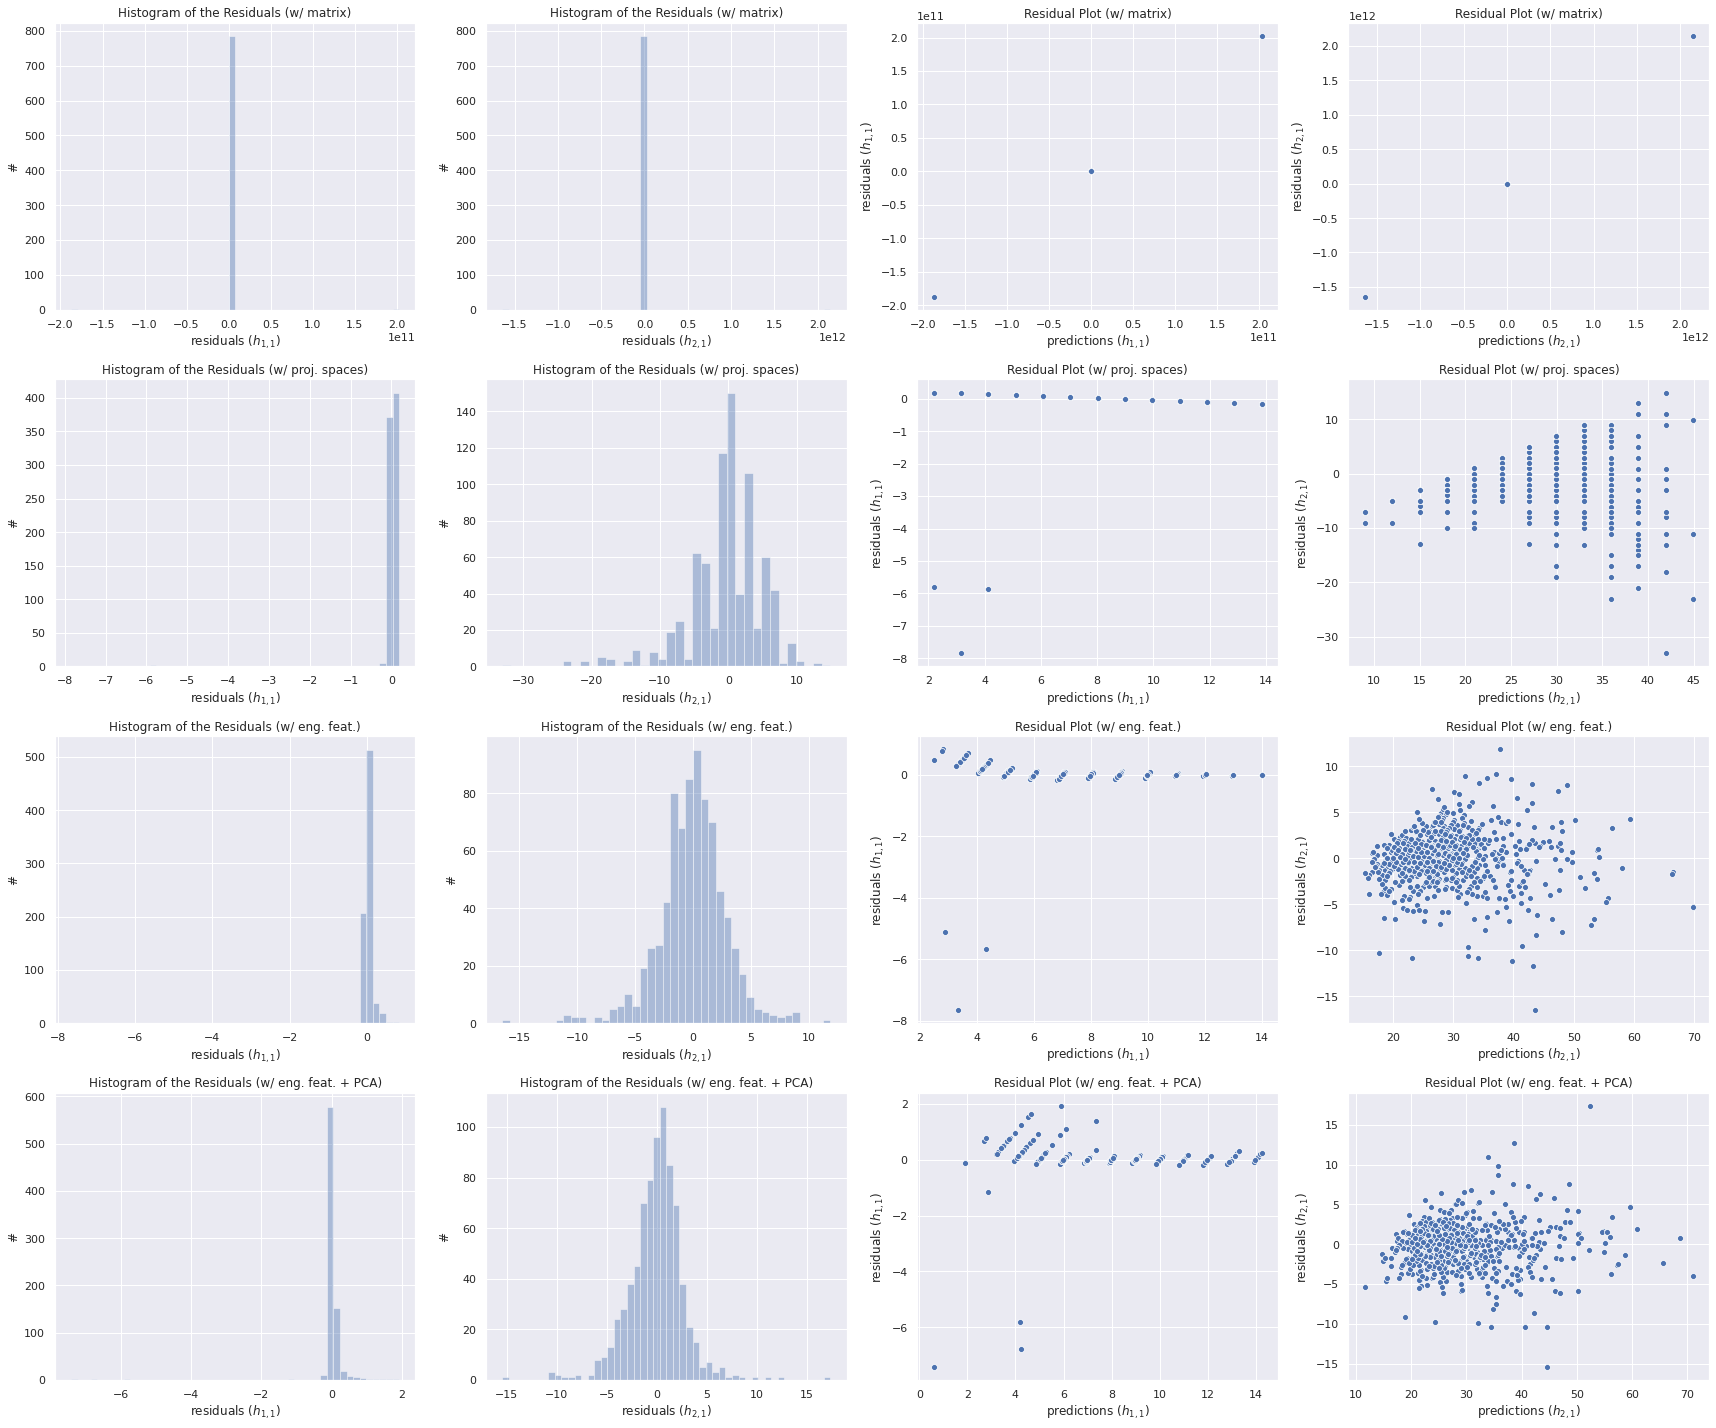

In [51]:
residual_plots(lin_reg_res, lin_reg_pred, 'lin_reg')

We finally save the predictions to file:

In [52]:
lin_reg_metrics.to_csv(outpath('lin_reg_metrics.csv'), index=True)
lin_reg_pred.to_csv(outpath('lin_reg_pred.csv'), index=True)
lin_reg_res.to_csv(outpath('lin_reg_res.csv'), index=True)

## Elastic Net

In [53]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics      import make_scorer
from skopt                import BayesSearchCV
from skopt.space          import Categorical, Real, Integer

# define the estimator
src_spc = {'alpha':         Real(1.0e-2, 1.0e2, prior='log-uniform'),
           'l1_ratio':      Real(0.0, 1.0),
           'fit_intercept': Integer(0,1),
           'normalize':     Integer(0,1)
          }
els_net = BayesSearchCV(ElasticNet(max_iter=1e5,
                                   random_state=RAND
                                  ),
                        search_spaces=src_spc,
                        n_iter=15,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
els_net_pred = {}
els_net_hypr = {}
log.info('Fitting the elastic net.')

# fit the estimator and compute predictions
els_net.fit(mat_comp_train, h11_train)
els_net_pred['mat_comp_h11'] = els_net.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
els_net_hypr['mat_comp_h11'] = dict(els_net.best_params_)
els_net.fit(proj_spc_train, h11_train)
els_net_pred['proj_spc_h11'] = els_net.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
els_net_hypr['proj_spc_h11'] = dict(els_net.best_params_)
els_net.fit(engf_h11_train, h11_train)
els_net_pred['eng_feat_h11'] = els_net.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
els_net_hypr['eng_feat_h11'] = dict(els_net.best_params_)
els_net.fit(comb_h11_train, h11_train)
els_net_pred['combined_h11'] = els_net.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
els_net_hypr['combined_h11'] = dict(els_net.best_params_)

els_net.fit(mat_comp_train, h21_train)
els_net_pred['mat_comp_h21'] = els_net.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
els_net_hypr['mat_comp_h21'] = dict(els_net.best_params_)
els_net.fit(proj_spc_train, h21_train)
els_net_pred['proj_spc_h21'] = els_net.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
els_net_hypr['proj_spc_h21'] = dict(els_net.best_params_)
els_net.fit(engf_h21_train, h21_train)
els_net_pred['eng_feat_h21'] = els_net.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
els_net_hypr['eng_feat_h21'] = dict(els_net.best_params_)
els_net.fit(comb_h21_train, h21_train)
els_net_pred['combined_h21'] = els_net.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
els_net_hypr['combined_h21'] = dict(els_net.best_params_)

KeyboardInterrupt: 

We then print the metrics:

In [ ]:
els_net_metrics = {'mat_comp': [accuracy(h11_test,
                                         els_net_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         els_net_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         els_net_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         els_net_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         els_net_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         els_net_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         els_net_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         els_net_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
els_net_metrics = pd.DataFrame(els_net_metrics, index=['h11', 'h21'])
els_net_metrics

We then take a look at the hyperparameters:

In [ ]:
els_net_hypr = pd.DataFrame(els_net_hypr)
els_net_hypr

We then store the predictions and plot the residuals:

In [ ]:
els_net_pred = pd.DataFrame(els_net_pred)
els_net_h11_res = els_net_pred.filter(regex='.*_h11$').subtract(h11_test)
els_net_h21_res = els_net_pred.filter(regex='.*_h21$').subtract(h21_test)
els_net_res = pd.merge(els_net_h11_res,
                       els_net_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(els_net_res, els_net_pred, 'els_net')

We finally save the predictions to file:

In [ ]:
els_net_metrics.to_csv(outpath('els_net_metrics.csv'), index=True)
els_net_pred.to_csv(outpath('els_net_pred.csv'), index=True)
els_net_res.to_csv(outpath('els_net_res.csv'), index=True)
els_net_hypr.to_csv(outpath('els_net_hypr.csv'), index=True)

## Lasso

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics      import make_scorer
from skopt                import BayesSearchCV
from skopt.space          import Categorical, Real, Integer

# define the estimator
src_spc = {'alpha': Real(1.0e-4, 1.0e2, prior='log-uniform'),
           'fit_intercept': Integer(0,1),
           'normalize':     Integer(0,1)
          }
lss_reg = BayesSearchCV(Lasso(max_iter=1e5,
                              random_state=RAND
                             ),
                        search_spaces=src_spc,
                        n_iter=15,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
lss_reg_pred = {}
lss_reg_hypr = {}
log.info('Fitting the lasso regression.')

# fit the estimator and compute predictions
lss_reg.fit(mat_comp_train, h11_train)
lss_reg_pred['mat_comp_h11'] = lss_reg.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
lss_reg_hypr['mat_comp_h11'] = dict(lss_reg.best_params_)
lss_reg.fit(proj_spc_train, h11_train)
lss_reg_pred['proj_spc_h11'] = lss_reg.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
lss_reg_hypr['proj_spc_h11'] = dict(lss_reg.best_params_)
lss_reg.fit(engf_h11_train, h11_train)
lss_reg_pred['eng_feat_h11'] = lss_reg.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
lss_reg_hypr['eng_feat_h11'] = dict(lss_reg.best_params_)
lss_reg.fit(comb_h11_train, h11_train)
lss_reg_pred['combined_h11'] = lss_reg.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
lss_reg_hypr['combined_h11'] = dict(lss_reg.best_params_)

lss_reg.fit(mat_comp_train, h21_train)
lss_reg_pred['mat_comp_h21'] = lss_reg.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
lss_reg_hypr['mat_comp_h21'] = dict(lss_reg.best_params_)
lss_reg.fit(proj_spc_train, h21_train)
lss_reg_pred['proj_spc_h21'] = lss_reg.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
lss_reg_hypr['proj_spc_h21'] = dict(lss_reg.best_params_)
lss_reg.fit(engf_h21_train, h21_train)
lss_reg_pred['eng_feat_h21'] = lss_reg.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
lss_reg_hypr['eng_feat_h21'] = dict(lss_reg.best_params_)
lss_reg.fit(comb_h21_train, h21_train)
lss_reg_pred['combined_h21'] = lss_reg.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
lss_reg_hypr['combined_h21'] = dict(lss_reg.best_params_)

We then print the metrics:

In [ ]:
lss_reg_metrics = {'mat_comp': [accuracy(h11_test,
                                         lss_reg_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lss_reg_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         lss_reg_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lss_reg_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         lss_reg_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lss_reg_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         lss_reg_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lss_reg_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
lss_reg_metrics = pd.DataFrame(lss_reg_metrics, index=['h11', 'h21'])
lss_reg_metrics

We then take a look at the hyperparameters:

In [ ]:
lss_reg_hypr = pd.DataFrame(lss_reg_hypr)
lss_reg_hypr

We then store the predictions and plot the residuals:

In [ ]:
lss_reg_pred = pd.DataFrame(lss_reg_pred)
lss_reg_h11_res = lss_reg_pred.filter(regex='.*_h11$').subtract(h11_test)
lss_reg_h21_res = lss_reg_pred.filter(regex='.*_h21$').subtract(h21_test)
lss_reg_res = pd.merge(lss_reg_h11_res,
                       lss_reg_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(lss_reg_res, lss_reg_pred, 'lss_reg')

We finally save the predictions to file:

In [ ]:
lss_reg_metrics.to_csv(outpath('lss_reg_metrics.csv'), index=True)
lss_reg_pred.to_csv(outpath('lss_reg_pred.csv'), index=True)
lss_reg_res.to_csv(outpath('lss_reg_res.csv'), index=True)
lss_reg_hypr.to_csv(outpath('lss_reg_hypr.csv'), index=True)

## Ridge

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics      import make_scorer
from skopt                import BayesSearchCV
from skopt.space          import Categorical, Real, Integer

# define the estimator
src_spc = {'alpha':         Real(1.0e-4, 1.0e2, prior='log-uniform'),
           'fit_intercept': Integer(0,1),
           'normalize':     Integer(0,1)
          }
rdg_reg = BayesSearchCV(Ridge(random_state=RAND
                             ),
                        search_spaces=src_spc,
                        n_iter=30,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
rdg_reg_pred = {}
rdg_reg_hypr = {}
log.info('Fitting the ridge regression.')

# fit the estimator and compute predictions
rdg_reg.fit(mat_comp_train, h11_train)
rdg_reg_pred['mat_comp_h11'] = rdg_reg.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
rdg_reg_hypr['mat_comp_h11'] = dict(rdg_reg.best_params_)
rdg_reg.fit(proj_spc_train, h11_train)
rdg_reg_pred['proj_spc_h11'] = rdg_reg.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
rdg_reg_hypr['proj_spc_h11'] = dict(rdg_reg.best_params_)
rdg_reg.fit(engf_h11_train, h11_train)
rdg_reg_pred['eng_feat_h11'] = rdg_reg.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
rdg_reg_hypr['eng_feat_h11'] = dict(rdg_reg.best_params_)
rdg_reg.fit(comb_h11_train, h11_train)
rdg_reg_pred['combined_h11'] = rdg_reg.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
rdg_reg_hypr['combined_h11'] = dict(rdg_reg.best_params_)

rdg_reg.fit(mat_comp_train, h21_train)
rdg_reg_pred['mat_comp_h21'] = rdg_reg.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
rdg_reg_hypr['mat_comp_h21'] = dict(rdg_reg.best_params_)
rdg_reg.fit(proj_spc_train, h21_train)
rdg_reg_pred['proj_spc_h21'] = rdg_reg.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
rdg_reg_hypr['proj_spc_h21'] = dict(rdg_reg.best_params_)
rdg_reg.fit(engf_h21_train, h21_train)
rdg_reg_pred['eng_feat_h21'] = rdg_reg.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
rdg_reg_hypr['eng_feat_h21'] = dict(rdg_reg.best_params_)
rdg_reg.fit(comb_h21_train, h21_train)
rdg_reg_pred['combined_h21'] = rdg_reg.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
rdg_reg_hypr['combined_h21'] = dict(rdg_reg.best_params_)

We then print the metrics:

In [ ]:
rdg_reg_metrics = {'mat_comp': [accuracy(h11_test,
                                         rdg_reg_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rdg_reg_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         rdg_reg_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rdg_reg_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         rdg_reg_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rdg_reg_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         rdg_reg_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rdg_reg_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
rdg_reg_metrics = pd.DataFrame(rdg_reg_metrics, index=['h11', 'h21'])
rdg_reg_metrics

We then take a look at the hyperparameters:

In [ ]:
rdg_reg_hypr = pd.DataFrame(rdg_reg_hypr)
rdg_reg_hypr

We then store the predictions and plot the residuals:

In [ ]:
rdg_reg_pred = pd.DataFrame(rdg_reg_pred)
rdg_reg_h11_res = rdg_reg_pred.filter(regex='.*_h11$').subtract(h11_test)
rdg_reg_h21_res = rdg_reg_pred.filter(regex='.*_h21$').subtract(h21_test)
rdg_reg_res = pd.merge(rdg_reg_h11_res,
                       rdg_reg_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(rdg_reg_res, rdg_reg_pred, 'rdg_reg')

We finally save the predictions to file:

In [ ]:
rdg_reg_metrics.to_csv(outpath('rdg_reg_metrics.csv'), index=True)
rdg_reg_pred.to_csv(outpath('rdg_reg_pred.csv'), index=True)
rdg_reg_res.to_csv(outpath('rdg_reg_res.csv'), index=True)
rdg_reg_hypr.to_csv(outpath('rdg_reg_hypr.csv'), index=True)

## Linear SVR

In [ ]:
from sklearn.svm     import LinearSVR
from sklearn.metrics import make_scorer
from skopt           import BayesSearchCV
from skopt.space     import Categorical, Real, Integer

# define the estimator
src_spc = {'epsilon':           Real(0.0, 10.0),
           'C':                 Real(1.0e-3, 1.0e2, prior='log-uniform'),
           'loss':              Categorical(['epsilon_insensitive',
                                             'squared_epsilon_insensitive'
                                            ]
                                           ),
           'fit_intercept':     Integer(0,1),
           'intercept_scaling': Real(1.0e-2, 1.0e2, prior='log-uniform')
          }
lin_svr = BayesSearchCV(LinearSVR(fit_intercept=False,
                                  max_iter=1e5,
                                  random_state=RAND
                                 ),
                        search_spaces=src_spc,
                        n_iter=30,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
lin_svr_pred = {}
lin_svr_hypr = {}
log.info('Fitting the linear SVR.')

# fit the estimator and compute predictions
lin_svr.fit(mat_comp_train, h11_train.reshape(-1,))
lin_svr_pred['mat_comp_h11'] = lin_svr.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
lin_svr_hypr['mat_comp_h11'] = dict(lin_svr.best_params_)
lin_svr.fit(proj_spc_train, h11_train.reshape(-1,))
lin_svr_pred['proj_spc_h11'] = lin_svr.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
lin_svr_hypr['proj_spc_h11'] = dict(lin_svr.best_params_)
lin_svr.fit(engf_h11_train, h11_train.reshape(-1,))
lin_svr_pred['eng_feat_h11'] = lin_svr.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
lin_svr_hypr['eng_feat_h11'] = dict(lin_svr.best_params_)
lin_svr.fit(comb_h11_train, h11_train)
lin_svr_pred['combined_h11'] = lin_svr.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
lin_svr_hypr['combined_h11'] = dict(lin_svr.best_params_)

lin_svr.fit(mat_comp_train, h21_train.reshape(-1,))
lin_svr_pred['mat_comp_h21'] = lin_svr.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
lin_svr_hypr['mat_comp_h21'] = dict(lin_svr.best_params_)
lin_svr.fit(proj_spc_train, h21_train.reshape(-1,))
lin_svr_pred['proj_spc_h21'] = lin_svr.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
lin_svr_hypr['proj_spc_h21'] = dict(lin_svr.best_params_)
lin_svr.fit(engf_h21_train, h21_train.reshape(-1,))
lin_svr_pred['eng_feat_h21'] = lin_svr.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
lin_svr_hypr['eng_feat_h21'] = dict(lin_svr.best_params_)
lin_svr.fit(comb_h21_train, h21_train.reshape(-1,))
lin_svr_pred['combined_h21'] = lin_svr.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
lin_svr_hypr['combined_h21'] = dict(lin_svr.best_params_)

We then print the metrics:

In [ ]:
lin_svr_metrics = {'mat_comp': [accuracy(h11_test,
                                         lin_svr_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_svr_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         lin_svr_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_svr_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         lin_svr_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_svr_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         lin_svr_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         lin_svr_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
lin_svr_metrics = pd.DataFrame(lin_svr_metrics, index=['h11', 'h21'])
lin_svr_metrics

We then take a look at the hyperparameters:

In [ ]:
lin_svr_hypr = pd.DataFrame(lin_svr_hypr)
lin_svr_hypr

We then store the predictions and plot the residuals:

In [ ]:
lin_svr_pred = pd.DataFrame(lin_svr_pred)
lin_svr_h11_res = lin_svr_pred.filter(regex='.*_h11$').subtract(h11_test)
lin_svr_h21_res = lin_svr_pred.filter(regex='.*_h21$').subtract(h21_test)
lin_svr_res = pd.merge(lin_svr_h11_res,
                       lin_svr_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(lin_svr_res, lin_svr_pred, 'lin_svr')

We finally save the predictions to file:

In [ ]:
lin_svr_metrics.to_csv(outpath('lin_svr_metrics.csv'), index=True)
lin_svr_pred.to_csv(outpath('lin_svr_pred.csv'), index=True)
lin_svr_res.to_csv(outpath('lin_svr_res.csv'), index=True)
lin_svr_hypr.to_csv(outpath('lin_svr_hypr.csv'), index=True)

## Gaussian SVR

In [ ]:
from sklearn.svm     import SVR
from sklearn.metrics import make_scorer
from skopt           import BayesSearchCV
from skopt.space     import Categorical, Real, Integer

# define the estimator
src_spc = {'gamma':   Real(1.0e-2, 1.0e3, prior='log-uniform'),
           'C':       Real(1.0e0, 1.0e3, prior='log-uniform'),
           'epsilon': Real(1.0e-2, 1.0e2, prior='log-uniform')
          }
svr_rbf = BayesSearchCV(SVR(kernel='rbf'),
                        search_spaces=src_spc,
                        n_iter=50,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
svr_rbf_pred = {}
svr_rbf_hypr = {}
log.info('Fitting the Gaussian SVR.')

# fit the estimator and compute predictions
svr_rbf.fit(mat_comp_train, h11_train.reshape(-1,))
svr_rbf_pred['mat_comp_h11'] = svr_rbf.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
svr_rbf_hypr['mat_comp_h11'] = dict(svr_rbf.best_params_)
svr_rbf.fit(proj_spc_train, h11_train.reshape(-1,))
svr_rbf_pred['proj_spc_h11'] = svr_rbf.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
svr_rbf_hypr['proj_spc_h11'] = dict(svr_rbf.best_params_)
svr_rbf.fit(engf_h11_train, h11_train.reshape(-1,))
svr_rbf_pred['eng_feat_h11'] = svr_rbf.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
svr_rbf_hypr['eng_feat_h11'] = dict(svr_rbf.best_params_)
svr_rbf.fit(comb_h11_train, h11_train.reshape(-1,))
svr_rbf_pred['combined_h11'] = svr_rbf.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
svr_rbf_hypr['combined_h11'] = dict(svr_rbf.best_params_)

svr_rbf.fit(mat_comp_train, h21_train.reshape(-1,))
svr_rbf_pred['mat_comp_h21'] = svr_rbf.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
svr_rbf_hypr['mat_comp_h21'] = dict(svr_rbf.best_params_)
svr_rbf.fit(proj_spc_train, h21_train.reshape(-1,))
svr_rbf_pred['proj_spc_h21'] = svr_rbf.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
svr_rbf_hypr['proj_spc_h21'] = dict(svr_rbf.best_params_)
svr_rbf.fit(engf_h21_train, h21_train.reshape(-1,))
svr_rbf_pred['eng_feat_h21'] = svr_rbf.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
svr_rbf_hypr['eng_feat_h21'] = dict(svr_rbf.best_params_)
svr_rbf.fit(comb_h21_train, h21_train.reshape(-1,))
svr_rbf_pred['combined_h21'] = svr_rbf.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
svr_rbf_hypr['combined_h21'] = dict(svr_rbf.best_params_)

We then print the metrics:

In [ ]:
svr_rbf_metrics = {'mat_comp': [accuracy(h11_test,
                                         svr_rbf_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         svr_rbf_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         svr_rbf_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         svr_rbf_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         svr_rbf_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         svr_rbf_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         svr_rbf_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         svr_rbf_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
svr_rbf_metrics = pd.DataFrame(svr_rbf_metrics, index=['h11', 'h21'])
svr_rbf_metrics

We then take a look at the hyperparameters:

In [ ]:
svr_rbf_hypr = pd.DataFrame(svr_rbf_hypr)
svr_rbf_hypr

We then store the predictions and plot the residuals:

In [ ]:
svr_rbf_pred = pd.DataFrame(svr_rbf_pred)
svr_rbf_h11_res = svr_rbf_pred.filter(regex='.*_h11$').subtract(h11_test)
svr_rbf_h21_res = svr_rbf_pred.filter(regex='.*_h21$').subtract(h21_test)
svr_rbf_res = pd.merge(svr_rbf_h11_res,
                       svr_rbf_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(svr_rbf_res, svr_rbf_pred, 'svr_rbf')

We finally save the predictions to file:

In [ ]:
svr_rbf_metrics.to_csv(outpath('svr_rbf_metrics.csv'), index=True)
svr_rbf_pred.to_csv(outpath('svr_rbf_pred.csv'), index=True)
svr_rbf_res.to_csv(outpath('svr_rbf_res.csv'), index=True)
svr_rbf_hypr.to_csv(outpath('svr_rbf_hypr.csv'), index=True)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics  import make_scorer
from skopt            import BayesSearchCV
from skopt.space      import Categorical, Real, Integer

# define the estimator
src_spc = {'n_estimators':             Integer(1e1, 3e2, prior='log-uniform'),
           'max_depth':                Integer(2, 100, prior='uniform'),
           'min_samples_split':        Integer(2, 100, prior='uniform'),
           'min_samples_leaf':         Integer(1, 100, prior='uniform'),
           'max_leaf_nodes':           Integer(2, 100, prior='uniform'),
           'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
           'criterion':                Categorical(['mse', 'mae'])
          } 
rnd_for = BayesSearchCV(RandomForestRegressor(random_state=RAND),
                        search_spaces=src_spc,
                        n_iter=25,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
rnd_for_pred = {}
rnd_for_hypr = {}
log.info('Fitting the random forest.')

# fit the estimator and compute predictions
rnd_for.fit(mat_comp_train, h11_train.reshape(-1,))
rnd_for_pred['mat_comp_h11'] = rnd_for.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
rnd_for_hypr['mat_comp_h11'] = dict(rnd_for.best_params_)
rnd_for.fit(proj_spc_train, h11_train.reshape(-1,))
rnd_for_pred['proj_spc_h11'] = rnd_for.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
rnd_for_hypr['proj_spc_h11'] = dict(rnd_for.best_params_)
rnd_for.fit(engf_h11_train, h11_train.reshape(-1,))
rnd_for_pred['eng_feat_h11'] = rnd_for.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
rnd_for_hypr['eng_feat_h11'] = dict(rnd_for.best_params_)
rnd_for.fit(comb_h11_train, h11_train.reshape(-1,))
rnd_for_pred['combined_h11'] = rnd_for.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
rnd_for_hypr['combined_h11'] = dict(rnd_for.best_params_)

rnd_for.fit(mat_comp_train, h21_train.reshape(-1,))
rnd_for_pred['mat_comp_h21'] = rnd_for.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
rnd_for_hypr['mat_comp_h21'] = dict(rnd_for.best_params_)
rnd_for.fit(proj_spc_train, h21_train.reshape(-1,))
rnd_for_pred['proj_spc_h21'] = rnd_for.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
rnd_for_hypr['proj_spc_h21'] = dict(rnd_for.best_params_)
rnd_for.fit(engf_h21_train, h21_train.reshape(-1,))
rnd_for_pred['eng_feat_h21'] = rnd_for.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
rnd_for_hypr['eng_feat_h21'] = dict(rnd_for.best_params_)
rnd_for.fit(comb_h21_train, h21_train.reshape(-1,))
rnd_for_pred['combined_h21'] = rnd_for.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
rnd_for_hypr['combined_h21'] = dict(rnd_for.best_params_)

We then print the metrics:

In [ ]:
rnd_for_metrics = {'mat_comp': [accuracy(h11_test,
                                         rnd_for_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rnd_for_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         rnd_for_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rnd_for_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         rnd_for_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rnd_for_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         rnd_for_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         rnd_for_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
rnd_for_metrics = pd.DataFrame(rnd_for_metrics, index=['h11', 'h21'])
rnd_for_metrics

We then take a look at the hyperparameters:

In [ ]:
rnd_for_hypr = pd.DataFrame(rnd_for_hypr)
rnd_for_hypr

We then store the predictions and plot the residuals:

In [ ]:
rnd_for_pred = pd.DataFrame(rnd_for_pred)
rnd_for_h11_res = rnd_for_pred.filter(regex='.*_h11$').subtract(h11_test)
rnd_for_h21_res = rnd_for_pred.filter(regex='.*_h21$').subtract(h21_test)
rnd_for_res = pd.merge(rnd_for_h11_res,
                       rnd_for_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(rnd_for_res, rnd_for_pred, 'rnd_for')

We finally save the predictions to file:

In [ ]:
rnd_for_metrics.to_csv(outpath('rnd_for_metrics.csv'), index=True)
rnd_for_pred.to_csv(outpath('rnd_for_pred.csv'), index=True)
rnd_for_res.to_csv(outpath('rnd_for_res.csv'), index=True)
rnd_for_hypr.to_csv(outpath('rnd_for_hypr.csv'), index=True)

## Gradient Boosted Decision Trees

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import make_scorer
from skopt            import BayesSearchCV
from skopt.space      import Categorical, Real, Integer

# define the estimator
src_spc = {'n_estimators':             Integer(1e1, 3e2, prior='log-uniform'),
           'max_depth':                Integer(2, 100, prior='uniform'),
           'min_samples_split':        Integer(2, 100, prior='uniform'),
           'learning_rate':            Real(1.0e-4, 1.0e1,
                                            prior='log-uniform'
                                           ),
           'alpha':                    Real(0.01, 0.99, prior='uniform'),
           'min_weight_fraction_leaf': Real(0.0, 0.5,  prior='uniform'),
           'subsample':                Real(0.1, 1.0,  prior='uniform'),
           'criterion':                Categorical(['friedman_mse', 'mae']),
           'loss':                     Categorical(['ls', 'lad', 'huber'])
          }

grd_bst = BayesSearchCV(GradientBoostingRegressor(random_state=RAND),
                        search_spaces=src_spc,
                        n_iter=25,
                        scoring=make_scorer(accuracy, func=np.rint),
                        n_jobs=THREADS,
                        refit=True,
                        cv=cv,
                        random_state=RAND
                       )
grd_bst_pred = {}
grd_bst_hypr = {}
log.info('Fitting the gradient boosted trees.')

# fit the estimator and compute predictions
grd_bst.fit(mat_comp_train, h11_train.reshape(-1,))
grd_bst_pred['mat_comp_h11'] = grd_bst.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
grd_bst_hypr['mat_comp_h11'] = dict(grd_bst.best_params_)
grd_bst.fit(proj_spc_train, h11_train.reshape(-1,))
grd_bst_pred['proj_spc_h11'] = grd_bst.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
grd_bst_hypr['proj_spc_h11'] = dict(grd_bst.best_params_)
grd_bst.fit(engf_h11_train, h11_train.reshape(-1,))
grd_bst_pred['eng_feat_h11'] = grd_bst.best_estimator_.\
                                       predict(engf_h11_test).reshape(-1,)
grd_bst_hypr['eng_feat_h11'] = dict(grd_bst.best_params_)
grd_bst.fit(comb_h11_train, h11_train.reshape(-1,))
grd_bst_pred['combined_h11'] = grd_bst.best_estimator_.\
                                       predict(comb_h11_test).reshape(-1,)
grd_bst_hypr['combined_h11'] = dict(grd_bst.best_params_)

grd_bst.fit(mat_comp_train, h21_train.reshape(-1,))
grd_bst_pred['mat_comp_h21'] = grd_bst.best_estimator_.\
                                       predict(mat_comp_test).reshape(-1,)
grd_bst_hypr['mat_comp_h21'] = dict(grd_bst.best_params_)
grd_bst.fit(proj_spc_train, h21_train.reshape(-1,))
grd_bst_pred['proj_spc_h21'] = grd_bst.best_estimator_.\
                                       predict(proj_spc_test).reshape(-1,)
grd_bst_hypr['proj_spc_h21'] = dict(grd_bst.best_params_)
grd_bst.fit(engf_h21_train, h21_train.reshape(-1,))
grd_bst_pred['eng_feat_h21'] = grd_bst.best_estimator_.\
                                       predict(engf_h21_test).reshape(-1,)
grd_bst_hypr['eng_feat_h21'] = dict(grd_bst.best_params_)
grd_bst.fit(comb_h21_train, h21_train.reshape(-1,))
grd_bst_pred['combined_h21'] = grd_bst.best_estimator_.\
                                       predict(comb_h21_test).reshape(-1,)
grd_bst_hypr['combined_h21'] = dict(grd_bst.best_params_)

We then print the metrics:

In [ ]:
grd_bst_metrics = {'mat_comp': [accuracy(h11_test,
                                         grd_bst_pred['mat_comp_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         grd_bst_pred['mat_comp_h21'],
                                         np.rint
                                        )
                               ],
                   'proj_spc': [accuracy(h11_test,
                                         grd_bst_pred['proj_spc_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         grd_bst_pred['proj_spc_h21'],
                                         np.rint
                                        )
                               ],
                   'eng_feat': [accuracy(h11_test,
                                         grd_bst_pred['eng_feat_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         grd_bst_pred['eng_feat_h21'],
                                         np.rint
                                        )
                               ],
                   'combined': [accuracy(h11_test,
                                         grd_bst_pred['combined_h11'],
                                         np.rint
                                        ),
                                accuracy(h21_test,
                                         grd_bst_pred['combined_h21'],
                                         np.rint
                                        )
                               ]
                  }

# save to data frame
grd_bst_metrics = pd.DataFrame(grd_bst_metrics, index=['h11', 'h21'])
grd_bst_metrics

We then take a look at the hyperparameters:

In [ ]:
grd_bst_hypr = pd.DataFrame(grd_bst_hypr)
grd_bst_hypr

We then store the predictions and plot the residuals:

In [ ]:
grd_bst_pred = pd.DataFrame(grd_bst_pred)
grd_bst_h11_res = grd_bst_pred.filter(regex='.*_h11$').subtract(h11_test)
grd_bst_h21_res = grd_bst_pred.filter(regex='.*_h21$').subtract(h21_test)
grd_bst_res = pd.merge(grd_bst_h11_res,
                       grd_bst_h21_res,
                       left_index=True,
                       right_index=True
                      )

residual_plots(grd_bst_res, grd_bst_pred, 'grd_bst')

We finally save the predictions to file:

In [ ]:
grd_bst_metrics.to_csv(outpath('grd_bst_metrics.csv'), index=True)
grd_bst_pred.to_csv(outpath('grd_bst_pred.csv'), index=True)
grd_bst_res.to_csv(outpath('grd_bst_res.csv'), index=True)
grd_bst_hypr.to_csv(outpath('grd_bst_hypr.csv'), index=True)